# Danucore - Recruitment Exercise

In this Jupyter notebook, we present a brief exercise related to our work at Danucore. This comprises two questions: the first involves analysis of PV data; and the second involves use of a publicly-available large language model of your choice.

These exercises should take a couple of hours at most, and we would like you to use this exercise to demonstrate your thinking around the problem.

## Q1 - Predicting PV Output

The accompanying CSV file contains daily PV output data and weather data collected from a single location, covering a period of 50 months. You may assume that this data has been collected using sensors installed at the location. The variables included in the data are as follows:

 - `precip`: daily aggregate liquid precipitation;
 - `cloud cover`: percentage of the visible sky that is covered by cloud;
 - `solar radiation`: solar radiation power (in W/m$^2$);
 - `humidity`: relative humidity (expressed as a percentage);
 - `pressure`: sea level atmospheric pressure (in millibars);
 - `UV index`: an indicator for the level of daily UV exposure, based on the amount of short-wave solar radiation and dependent on the cloud cover, type of cloud, altitude and time of year; 0 represents no exposure, 10 represents a high level of exposure;
 - `temp min`: minimum daily temperature
 - `temp max`: maximum daily temperature
 - `solar energy`: daily aggregate energy from the sun (in MJ/m$^2$)

- `PV output`: daily aggregate energy output (in kWh) from a PV array with maximum capacity of 1 kWp
     
Suppose we wish to use the first nine variables (or some subset of these) to predict the daily aggregate solar energy output given by the tenth variable. Suggest and implement a method for doing this: use the first two years of data for any model fitting, and use the final two months to illustrate your model's predictive ability.

If you are using ML methods, these do not need to be fully optimised, though you should demonstrate best practice in any model fitting procedures you implement. All implementation should be carried out in Python and within this notebook.



### Importing Required Libraries


In [1]:
%pip install xgboost

import numpy as np       # for data handling and visualization
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 


from sklearn.preprocessing import StandardScaler, MinMaxScaler   # for preprocessing

from sklearn.ensemble import RandomForestRegressor                # machine learning models
from xgboost import XGBRegressor
from sklearn.ensemble import IsolationForest, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor 

from sklearn.model_selection import GridSearchCV   # for hyper parameter tuning

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score   # for model evaluation

from sklearn.impute import KNNImputer    # for handling missing values
from scipy import stats                  # for statistical analysis

from sklearn.feature_selection import SelectKBest, mutual_info_regression # for feature selection and dimentionality reduction
from sklearn.decomposition import PCA



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Exploratory Data Analysis

### Load The Dataset


In [2]:
def explore_data():

    """
       this function aims to calculate the shape of dataset along with the count of variables and the count of observations
    """

    
    
    df = pd.read_csv(file_path)     # Load the csv file
    shape_of_dataset = df.shape
    print(f'the shape of dataset is:{shape_of_dataset}')
    
    number_of_observations = df.shape[0] 
    print(f'number of observations:{df.shape[0]}')
    
    number_of_variables = df.shape[1]
    print(f'number of variables:{df.shape[1]}')

    return df


file_path = './solarPower_50m.csv'
df = explore_data()
df



the shape of dataset is:(793, 11)
number of observations:793
number of variables:11


Unnamed: 0  precip  cloud cover  solar radiation  humidity  pressure  \
0    2019-12-01   0.000         72.0             27.9      87.3    1024.4   
1    2019-12-02   0.120         41.2              NaN      82.0    1032.6   
2    2019-12-03   0.000         59.8             42.5      82.6    1027.7   
3    2019-12-04   0.096         26.2             43.8      90.6    1020.7   
4    2019-12-05   0.134         85.2             26.5      91.5    1019.4   
..          ...     ...          ...              ...       ...       ...   
788  2022-01-27   0.605         64.0             23.6      91.7    1030.8   
789  2022-01-28   0.191         61.8             40.8      95.9    1035.6   
790  2022-01-29   1.226         77.8             31.0      93.5    1031.9   
791  2022-01-30   0.124         38.8             53.9      88.9    1031.4   
792  2022-01-31   0.773         73.0             35.6      79.0    1027.6   

     UV index  temp min  temp max  solar energy  PV output  
0         2.0       0.9       5.4           2.4      0.748  
1         2.0      -1.1       5.8           3.9      1.122  
2         3.0       2.1       8.2           3.7      1.091  
3         3.0       1.0       6.9           3.7      1.060  
4         2.0       1.9       9.7           2.3      0.712  
..        ...       ...       ...           ...        ...  
788       1.0       2.0      10.4           2.1      0.612  
789       2.0       0.6       9.1           3.5      0.401  
790       1.0       3.5      10.2           2.6      0.700  
791       3.0       0.4       8.0           4.7      1.313  
792       2.0       5.5       7.3           3.1      1.491  

[793 rows x 11 columns]

- As we can see the dataset has 793 rows and 11 columns with numerical data which are float64. 

we need the 'date' column for splitting so we need to keep this column.
but in our calculations like handling missing values or calculate correlation matrix, actually we ignore this column.
so we need to exclude it temporarily. 


#### Rename 'Unnamed: 0' column and create df_temporary for handling missing values

In [3]:
#we first rename Unnamed: 0 column to date because it contains date value
if 'Unnamed: 0' in df.columns:
    df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)


#now we convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# now we ignore this column(date) temporarily because we dont need in our calculation
df_date = df[['date']]

df

date  precip  cloud cover  solar radiation  humidity  pressure  \
0   2019-12-01   0.000         72.0             27.9      87.3    1024.4   
1   2019-12-02   0.120         41.2              NaN      82.0    1032.6   
2   2019-12-03   0.000         59.8             42.5      82.6    1027.7   
3   2019-12-04   0.096         26.2             43.8      90.6    1020.7   
4   2019-12-05   0.134         85.2             26.5      91.5    1019.4   
..         ...     ...          ...              ...       ...       ...   
788 2022-01-27   0.605         64.0             23.6      91.7    1030.8   
789 2022-01-28   0.191         61.8             40.8      95.9    1035.6   
790 2022-01-29   1.226         77.8             31.0      93.5    1031.9   
791 2022-01-30   0.124         38.8             53.9      88.9    1031.4   
792 2022-01-31   0.773         73.0             35.6      79.0    1027.6   

     UV index  temp min  temp max  solar energy  PV output  
0         2.0       0.9       5.4           2.4      0.748  
1         2.0      -1.1       5.8           3.9      1.122  
2         3.0       2.1       8.2           3.7      1.091  
3         3.0       1.0       6.9           3.7      1.060  
4         2.0       1.9       9.7           2.3      0.712  
..        ...       ...       ...           ...        ...  
788       1.0       2.0      10.4           2.1      0.612  
789       2.0       0.6       9.1           3.5      0.401  
790       1.0       3.5      10.2           2.6      0.700  
791       3.0       0.4       8.0           4.7      1.313  
792       2.0       5.5       7.3           3.1      1.491  

[793 rows x 11 columns]

In [4]:
df_temporary = df.drop(columns=['date'])   # temporarily  we ignore the column 'date'
df_temporary

precip  cloud cover  solar radiation  humidity  pressure  UV index  \
0     0.000         72.0             27.9      87.3    1024.4       2.0   
1     0.120         41.2              NaN      82.0    1032.6       2.0   
2     0.000         59.8             42.5      82.6    1027.7       3.0   
3     0.096         26.2             43.8      90.6    1020.7       3.0   
4     0.134         85.2             26.5      91.5    1019.4       2.0   
..      ...          ...              ...       ...       ...       ...   
788   0.605         64.0             23.6      91.7    1030.8       1.0   
789   0.191         61.8             40.8      95.9    1035.6       2.0   
790   1.226         77.8             31.0      93.5    1031.9       1.0   
791   0.124         38.8             53.9      88.9    1031.4       3.0   
792   0.773         73.0             35.6      79.0    1027.6       2.0   

     temp min  temp max  solar energy  PV output  
0         0.9       5.4           2.4      0.748  
1        -1.1       5.8           3.9      1.122  
2         2.1       8.2           3.7      1.091  
3         1.0       6.9           3.7      1.060  
4         1.9       9.7           2.3      0.712  
..        ...       ...           ...        ...  
788       2.0      10.4           2.1      0.612  
789       0.6       9.1           3.5      0.401  
790       3.5      10.2           2.6      0.700  
791       0.4       8.0           4.7      1.313  
792       5.5       7.3           3.1      1.491  

[793 rows x 10 columns]

### handling missing values

In [5]:
#checking for missing values in each column
def finding_missing_values(df):
    missing_values = df.isnull().sum()
    print("missing values count:\n", missing_values)
missing_values = finding_missing_values(df)
print(missing_values)



missing values count:
 date                0
precip              0
cloud cover         0
solar radiation    33
humidity            0
pressure            1
UV index            0
temp min            0
temp max            0
solar energy        0
PV output           0
dtype: int64
None


As we can see **solar radiation** has **33 missing values** and **pressure** has **only 1**. first we should know about what is the type of missing values , then we can handle them.
first we see the status of missing values visually.


#### Visualize Missing Data


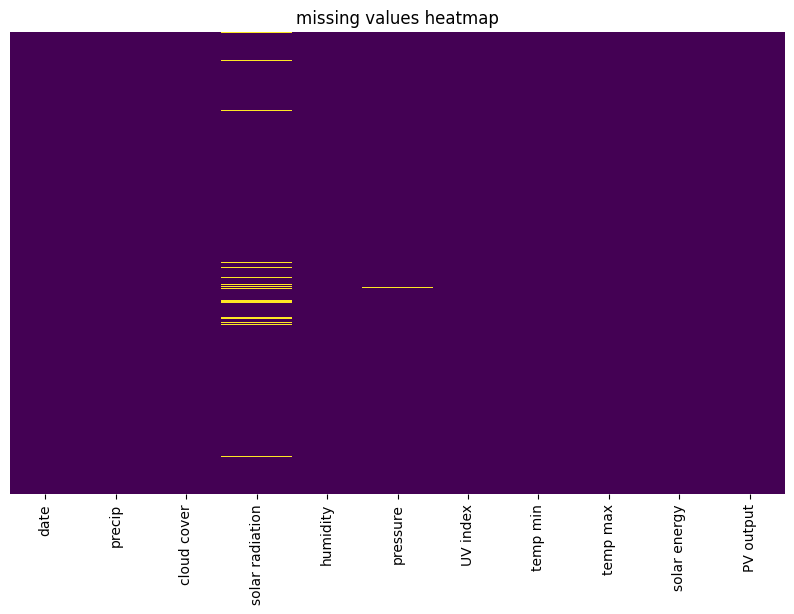

In [6]:
#heatmap to visualize missing values
plt.figure(figsize = (10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("missing values heatmap")
plt.show()

As we can see missingness in solar radiation is spread in certain areas.

#### Interpret Missing Values

there are three  types of missing values :

MCAR: Missing Completely At Random which means there is no correlation between variables containing missing values and other variables. in  our case this means there is no relationship between solar radiation and other variables.

MNAR:Missing Not At Random. missingness would have to be caused by solar radiation itself.for example sensor failure or equipment limitations.

MAR: Missing At Random, which means missing values are influenced by other known variables. in this case missingness correlates strongly with humidity, precipitation, or cloud cover. we should first of all check out this.


pressure only has 1 missing value and this is at random --->MCAR -simply we remove that

the most missing data is in solar radiation so we have to carefully handle these missing data.a few missing value in pressure so we can simply fill this using median or forward fill

#### Handle the Missing values in variable pressure

In [7]:
#pressure ---> MCAR
df_temporary['pressure'].isnull().sum()
df_temporary['pressure'].fillna(df_temporary['pressure'].median(), inplace=True)
# df_temporary['pressure']


/tmp/ipykernel_5727/553903251.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_temporary['pressure'].fillna(df_temporary['pressure'].median(), inplace=True)


In [8]:
df_temporary['pressure'].isnull().sum()


0

#### Handle Missing Values in variable solar radiation

##### Visualize the relationship between missing solar radiation and other variables

/tmp/ipykernel_5727/678428232.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = df_temporary['missing_solar_radiation'], y = df_temporary[feature], ax = axes[row, col], palette=colors)
/tmp/ipykernel_5727/678428232.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[row, col].set_xticklabels(['Not Missing', 'Missing'])
/tmp/ipykernel_5727/678428232.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = df_temporary['missing_solar_radiation'], y = df_temporary[feature], ax = axes[row, col], palette=colors)
/tmp/ipykernel_5727/678428232.py:17: UserWarning: set_ticklabels() should only be used w

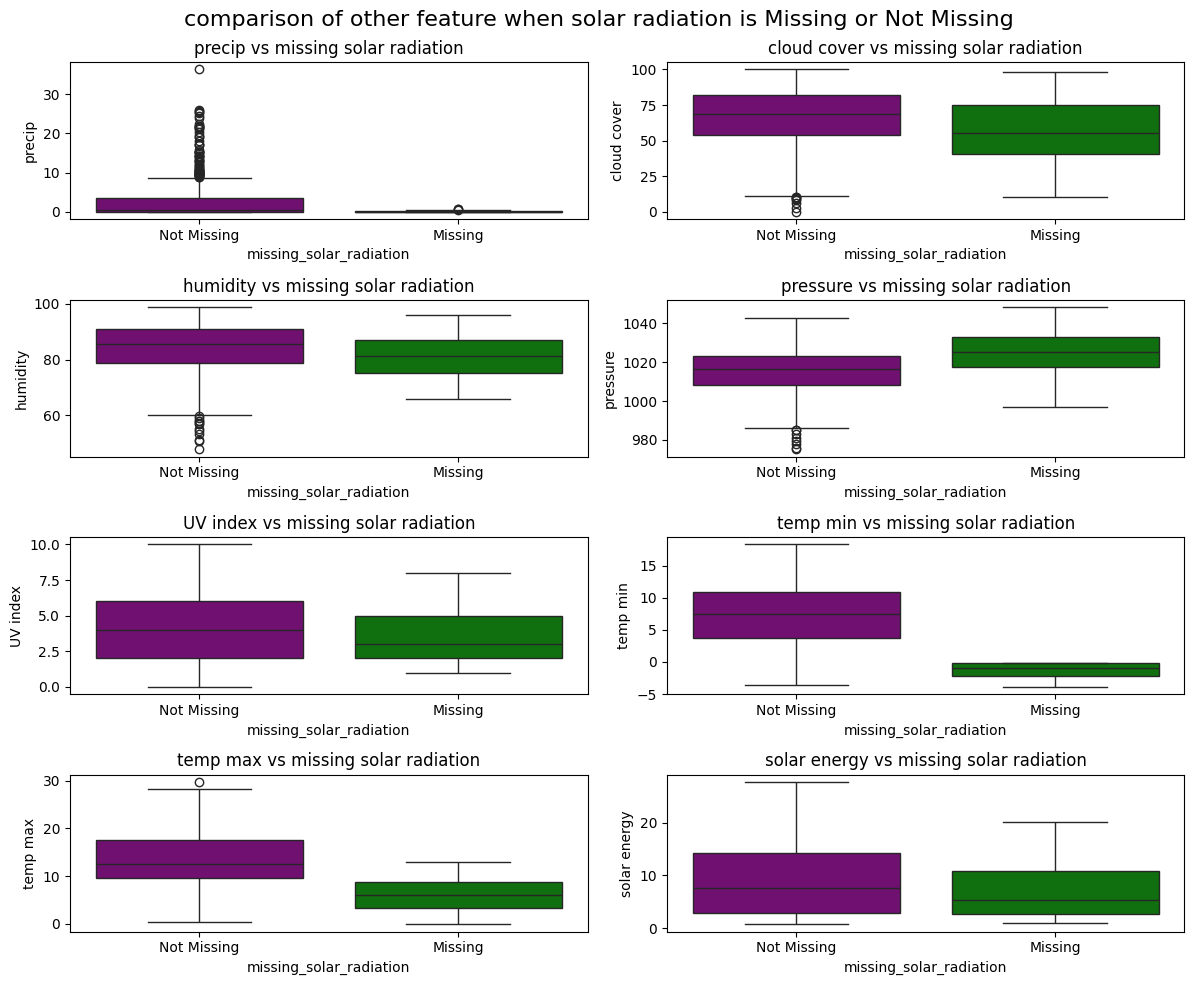

In [9]:
# first we create a new column which shows whether solar radiation is missing or not (1 = missing, 0 = not missing)
df_temporary['missing_solar_radiation'] = df_temporary['solar radiation'].isnull().astype(int)


#feature that we want to compare them with missing solar radiation
check_features = ['precip',	'cloud cover', 'humidity', 'pressure', 'UV index', 'temp min', 'temp max', 'solar energy'] 
colors = {'0': 'purple', '1' : 'green'}


# we draw a boxplot that compares the distribution of these features with when solar radiation is missing or not missing
fig, axes = plt.subplots(4, 2, figsize = (12, 10))
fig.suptitle('comparison of other feature when solar radiation is Missing or Not Missing', fontsize=16)
for i, feature in enumerate(check_features):
    row, col = divmod(i, 2)
    sns.boxplot(x = df_temporary['missing_solar_radiation'], y = df_temporary[feature], ax = axes[row, col], palette=colors)
    axes[row,col].set_title(f"{feature} vs missing solar radiation", fontsize=12)
    axes[row, col].set_xticklabels(['Not Missing', 'Missing'])


plt.tight_layout()
plt.show()

interpret the pattern of missing values in solar radiation :
from box plots we simply can see that **cloud cover** is higher when solar radiation is missing which means solar radiation is missing mostly in cloudy days.

also we can see that **precipitation** is slightly higher when solar radiation is missing, which means rainy days might affect on recording solar radiation.

**humidity** also is slightly higher when solar radiation is missing. so we can conclude humid weather also contribute on recording solar radiation.

other variables are lower when solar radiation is missing. which means missingness occurs mostly in cooler and low uv conditions.




since we found out the relationship between missingness and other variables we apply KNN imputation method becuase missingness depends on other features.---> MAR

what KNN Imputation does is that the algorithm sees the dataset, for each row with missing values it looks at other rows that have similar values for the available features.
it then calculates the distance (Euclidean Distance) between row with missing data and all other rows. then k nearest rows are selected. now the missing values are estimated using mean or median. then weightd average based on how close the neighbors are.
of k-nearest values, and the process is done for all the missing values.

#### Handling missing values in solar radiation with KNN Imputation

In [10]:
features_used_for_imputation = ['precip','cloud cover', 'solar radiation', 'humidity', 'pressure', 'UV index', 'temp min', 'temp max', 'solar energy']
# Apply KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)  # initialise knn imputer with 5 nearest neighbors
df_temporary[features_used_for_imputation] = knn_imputer.fit_transform(df_temporary[features_used_for_imputation])

#now check for missing values in variable solar radiation
missing_values_after_imputation = df_temporary['solar radiation'].isnull().sum()
print(f'missing values after imputation are :{missing_values_after_imputation}')

missing values after imputation are :0


In [11]:
# Another check to see if there is missing values
df_temporary.isnull().sum()

precip                     0
cloud cover                0
solar radiation            0
humidity                   0
pressure                   0
UV index                   0
temp min                   0
temp max                   0
solar energy               0
PV output                  0
missing_solar_radiation    0
dtype: int64

In [12]:
df_temporary

precip  cloud cover  solar radiation  humidity  pressure  UV index  \
0     0.000         72.0            27.90      87.3    1024.4       2.0   
1     0.120         41.2            52.58      82.0    1032.6       2.0   
2     0.000         59.8            42.50      82.6    1027.7       3.0   
3     0.096         26.2            43.80      90.6    1020.7       3.0   
4     0.134         85.2            26.50      91.5    1019.4       2.0   
..      ...          ...              ...       ...       ...       ...   
788   0.605         64.0            23.60      91.7    1030.8       1.0   
789   0.191         61.8            40.80      95.9    1035.6       2.0   
790   1.226         77.8            31.00      93.5    1031.9       1.0   
791   0.124         38.8            53.90      88.9    1031.4       3.0   
792   0.773         73.0            35.60      79.0    1027.6       2.0   

     temp min  temp max  solar energy  PV output  missing_solar_radiation  
0         0.9       5.4           2.4      0.748                        0  
1        -1.1       5.8           3.9      1.122                        1  
2         2.1       8.2           3.7      1.091                        0  
3         1.0       6.9           3.7      1.060                        0  
4         1.9       9.7           2.3      0.712                        0  
..        ...       ...           ...        ...                      ...  
788       2.0      10.4           2.1      0.612                        0  
789       0.6       9.1           3.5      0.401                        0  
790       3.5      10.2           2.6      0.700                        0  
791       0.4       8.0           4.7      1.313                        0  
792       5.5       7.3           3.1      1.491                        0  

[793 rows x 11 columns]

In [13]:
df_temporary = df_temporary.drop('missing_solar_radiation', axis = 1)  # we dont need the column 'missing_solar_radiation' anymore so we drop it
df_temporary

precip  cloud cover  solar radiation  humidity  pressure  UV index  \
0     0.000         72.0            27.90      87.3    1024.4       2.0   
1     0.120         41.2            52.58      82.0    1032.6       2.0   
2     0.000         59.8            42.50      82.6    1027.7       3.0   
3     0.096         26.2            43.80      90.6    1020.7       3.0   
4     0.134         85.2            26.50      91.5    1019.4       2.0   
..      ...          ...              ...       ...       ...       ...   
788   0.605         64.0            23.60      91.7    1030.8       1.0   
789   0.191         61.8            40.80      95.9    1035.6       2.0   
790   1.226         77.8            31.00      93.5    1031.9       1.0   
791   0.124         38.8            53.90      88.9    1031.4       3.0   
792   0.773         73.0            35.60      79.0    1027.6       2.0   

     temp min  temp max  solar energy  PV output  
0         0.9       5.4           2.4      0.748  
1        -1.1       5.8           3.9      1.122  
2         2.1       8.2           3.7      1.091  
3         1.0       6.9           3.7      1.060  
4         1.9       9.7           2.3      0.712  
..        ...       ...           ...        ...  
788       2.0      10.4           2.1      0.612  
789       0.6       9.1           3.5      0.401  
790       3.5      10.2           2.6      0.700  
791       0.4       8.0           4.7      1.313  
792       5.5       7.3           3.1      1.491  

[793 rows x 10 columns]

#### Count Missing values per Rows

In [14]:
#count missing values in each row
missing_per_row = df_temporary.isnull().sum(axis=1)

#display the number of missing values for the first rows
print(missing_per_row)

0      0
1      0
2      0
3      0
4      0
      ..
788    0
789    0
790    0
791    0
792    0
Length: 793, dtype: int64


### MinMax Ranges with Histogram

ranges:
precip              36.276
cloud cover        100.000
solar radiation    312.500
humidity            51.200
pressure            73.300
UV index            10.000
temp min            22.200
temp max            29.800
solar energy        27.000
PV output            6.795
dtype: float64


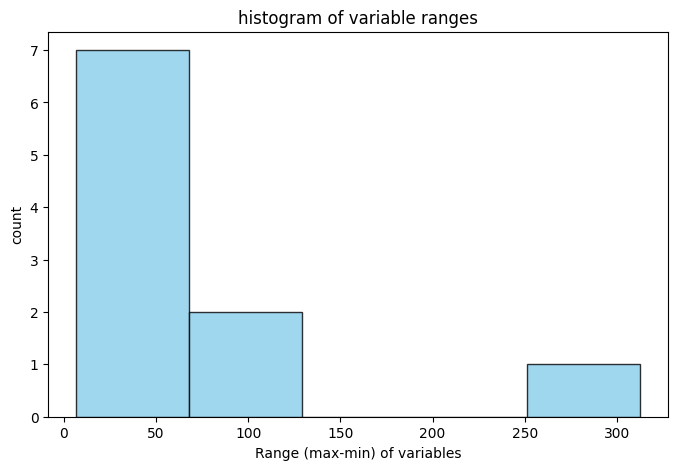

In [15]:
# we want to see the scales of all features in the dataset
def minimax_hist(df_temporary):
    max_values = df_temporary.max()  #calculate maximum values in each variable in dataset
    min_values = df_temporary.min()  # calculate the minimum values for each variable in dataset
    ranges = max_values - min_values
    print(f'ranges:\n{ranges}')
    # print(f'max values:{max_values}')
    # print(f'min values:{min_values}')

    #plotting the histogram of variable ranges
    plt.figure(figsize=(8, 5))
    plt.hist(ranges, bins = 5, alpha = 0.80, color = 'skyblue', edgecolor = 'black')
    plt.xlabel('Range (max-min) of variables')
    plt.ylabel('count')
    plt.title('histogram of variable ranges')
    plt.show()
minimax_hist(df_temporary)


what we can see from this graph is that the highest count of variablesa re in range of (~0 to 50).featues like humidity, uv-index, and pressure.

few variables like temp min and temp max have moderate variations. (~50 to 100)

solar radiation and solar energy has larg range (~300+)

### Pairwise Comparisons including PV output

<Figure size 1000x400 with 0 Axes>

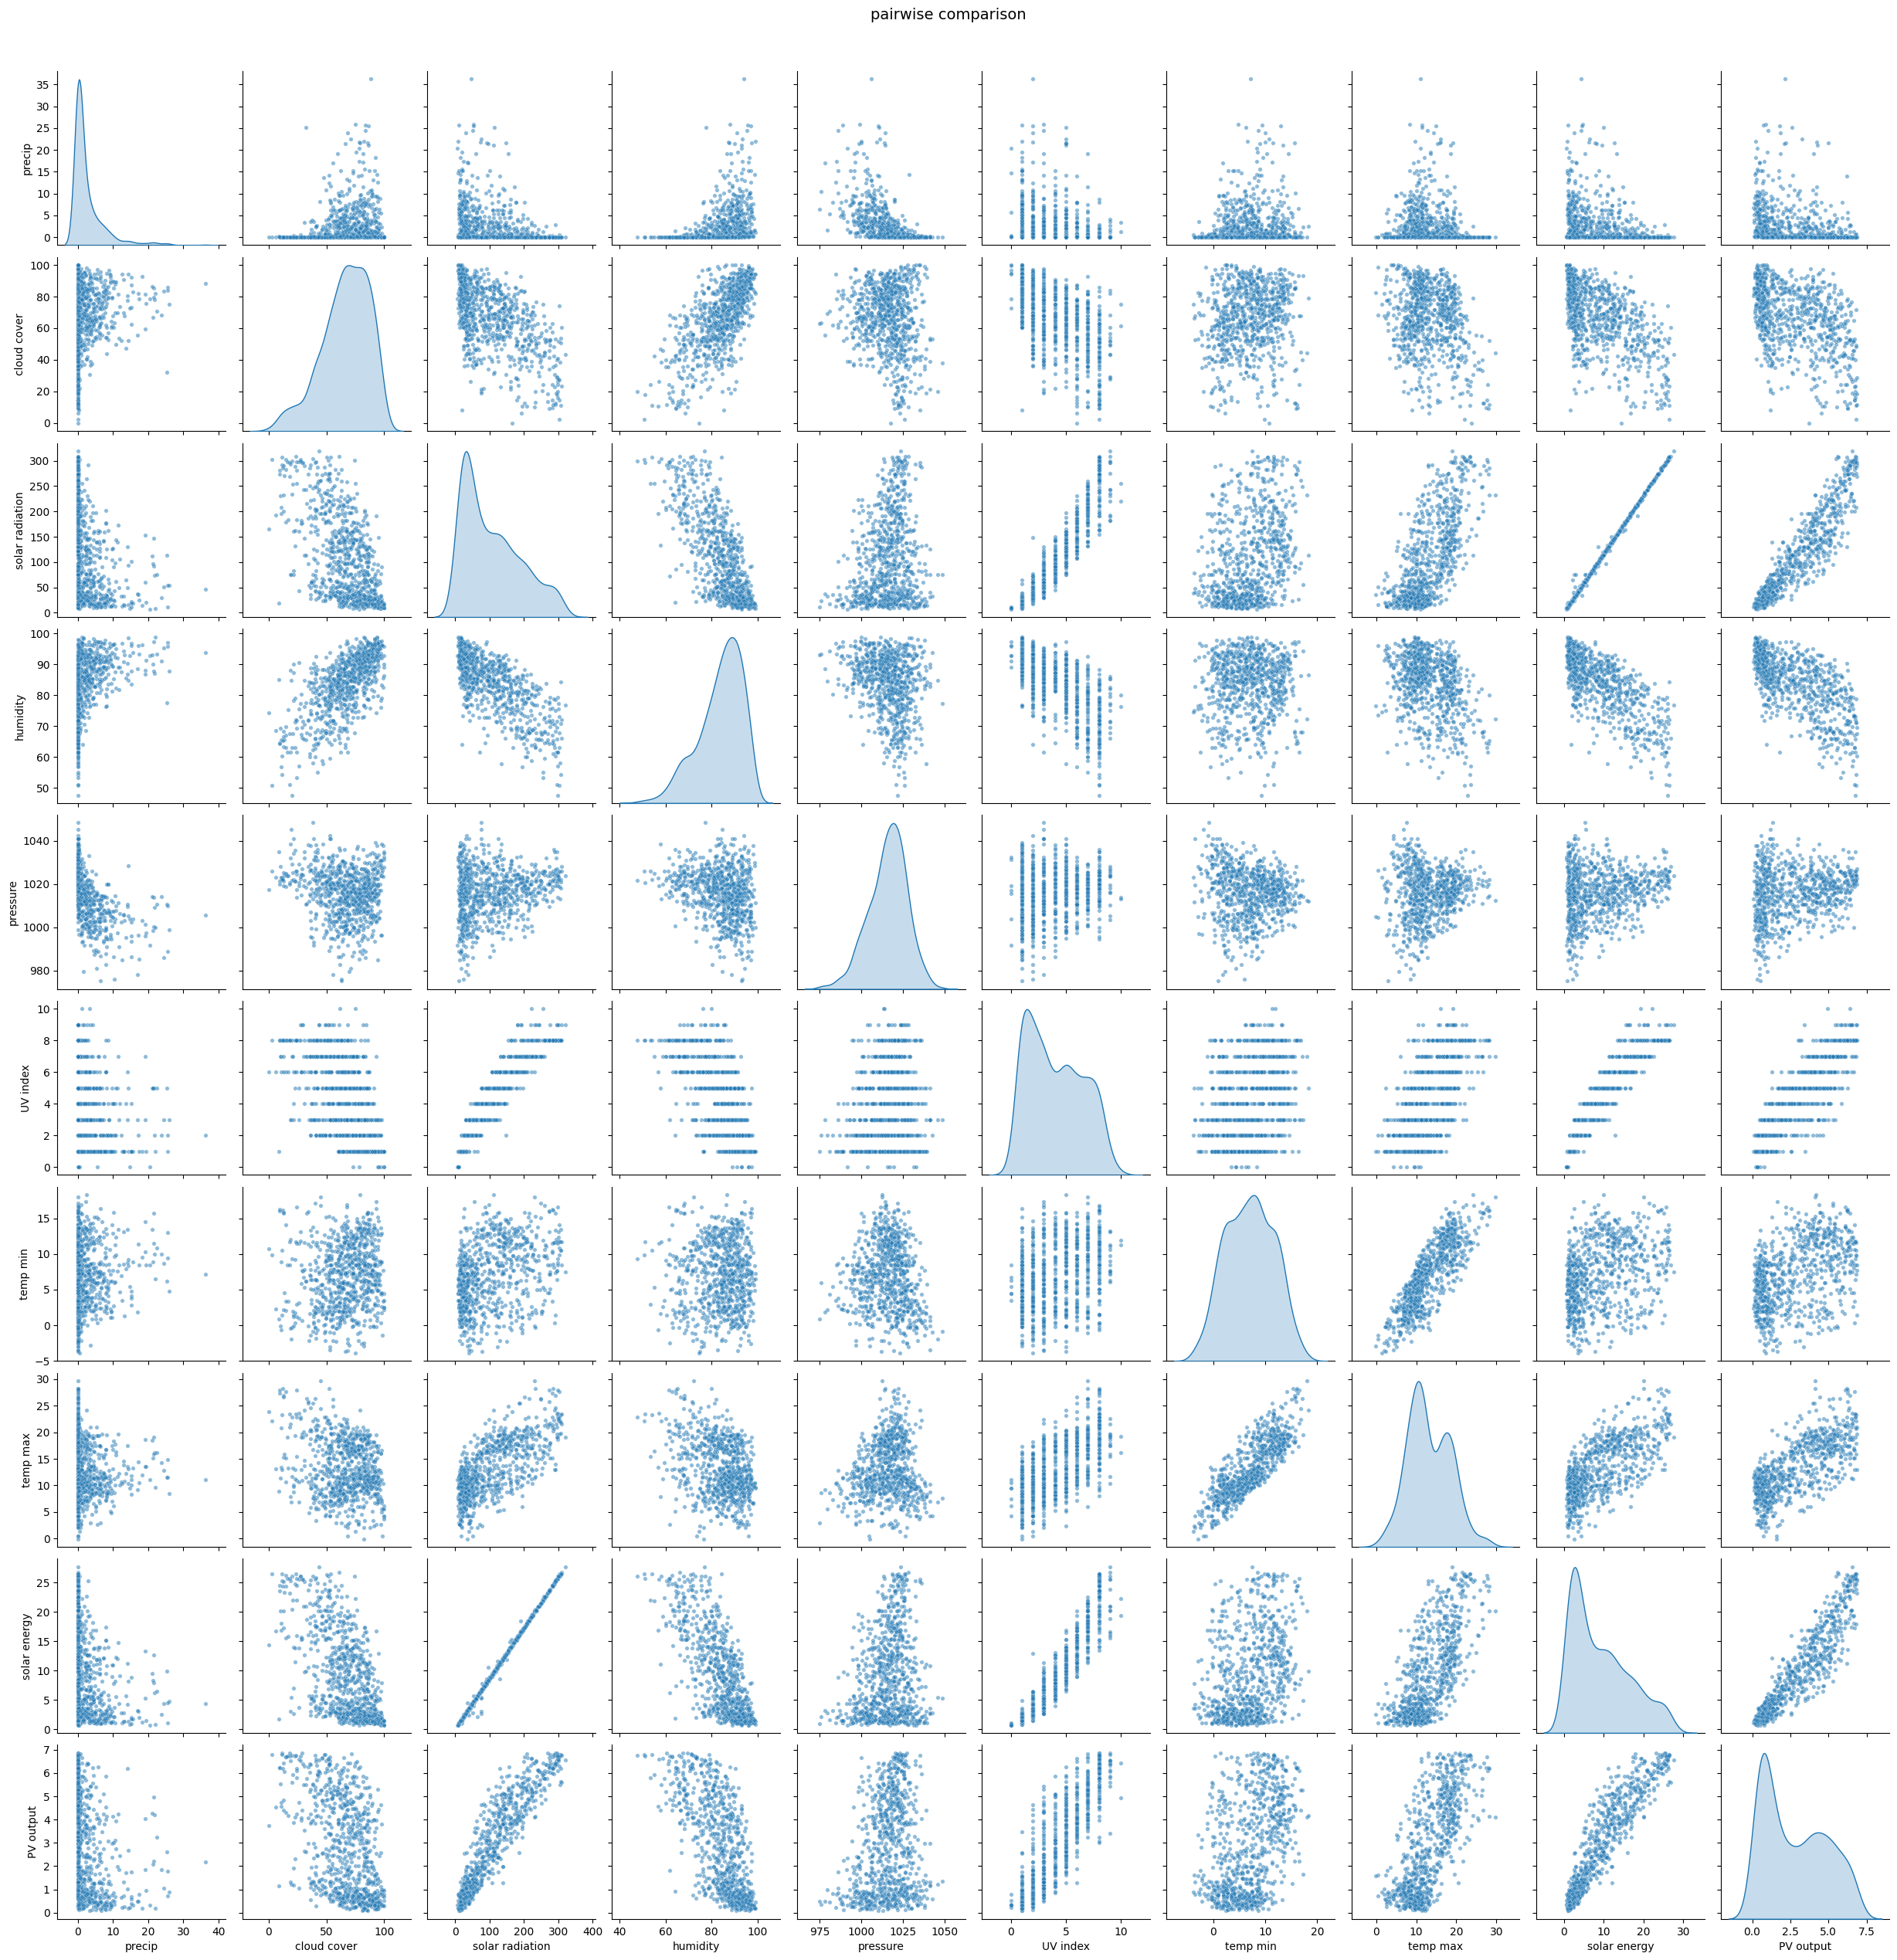

In [16]:
plt.figure(figsize=(10, 4))
sns.pairplot(df_temporary, diag_kind='kde', markers='o', plot_kws={'alpha':0.5, 's':15})
plt.suptitle('pairwise comparison', y=1.02, fontsize=14)
plt.show()

what we get from this graph is:

1- high correlation between solar radiation and solar energy

2- strong positive relationship between pv output/ solar radiation and solar energy

3- negative correlation between cloud cover and pv output. more clouds leads to lower pv output, which makes sense.

4- no clear relationship between precipitation and pv output

5- high correlation between temp min and temp max and also high relation between output and temp max


#### Calculating Correlation Matrix

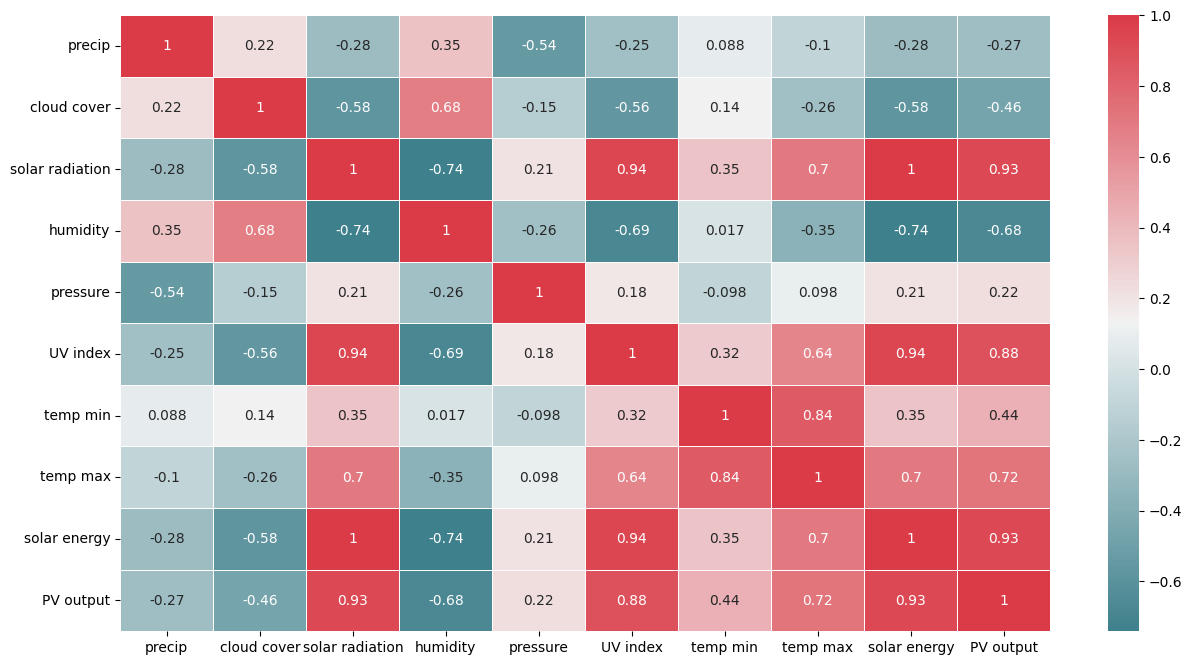

In [17]:
def correlation_matrix(df_temporary):
    fig, ax = plt.subplots(figsize= (15, 8))
    df_corr = df_temporary.corr()
    cmap = sns.diverging_palette(210, 10, as_cmap=True)
    sns.heatmap(df_corr, annot=True, cmap=cmap, linewidths= 0.7)
    plt.show()
correlation_matrix(df_temporary)

correlation with pv output:
-solar radiation(0.93), solar energy(0.93), and UV Index(0.88) which means higher values indicate better outputs.
-temp max (0.72) which means warmer conditions improve pv efficiency.
- cloud cover (-0.46), humidity (-0.68), and precipitation (-0.27) have strong negative correlation with pv output, which means these factors reduce pv output by limiting sunlight effect.
Another insight from the correlation matrix is correlation among the features themselves, which increase the risk of multicollinearity.
solar radiation and solar energy has correlation(1.00), UV Index(0.94). these features are highly correlated with each other and provide redundant information.
- temp max and solar radiation(0.7), uv index(0.64), solar energy (0.7). higher temperature correlates with solar intensity.
for handling this we will use VIF and PCA we can remove redundant features and finally find the best features that can represent the data perfectly.


In [18]:
df_final = pd.concat([df_date, df_temporary], axis = 1) #concatenate  date column with df_temporary because later we need this column for splitting into train and test
df_final

date  precip  cloud cover  solar radiation  humidity  pressure  \
0   2019-12-01   0.000         72.0            27.90      87.3    1024.4   
1   2019-12-02   0.120         41.2            52.58      82.0    1032.6   
2   2019-12-03   0.000         59.8            42.50      82.6    1027.7   
3   2019-12-04   0.096         26.2            43.80      90.6    1020.7   
4   2019-12-05   0.134         85.2            26.50      91.5    1019.4   
..         ...     ...          ...              ...       ...       ...   
788 2022-01-27   0.605         64.0            23.60      91.7    1030.8   
789 2022-01-28   0.191         61.8            40.80      95.9    1035.6   
790 2022-01-29   1.226         77.8            31.00      93.5    1031.9   
791 2022-01-30   0.124         38.8            53.90      88.9    1031.4   
792 2022-01-31   0.773         73.0            35.60      79.0    1027.6   

     UV index  temp min  temp max  solar energy  PV output  
0         2.0       0.9       5.4           2.4      0.748  
1         2.0      -1.1       5.8           3.9      1.122  
2         3.0       2.1       8.2           3.7      1.091  
3         3.0       1.0       6.9           3.7      1.060  
4         2.0       1.9       9.7           2.3      0.712  
..        ...       ...       ...           ...        ...  
788       1.0       2.0      10.4           2.1      0.612  
789       2.0       0.6       9.1           3.5      0.401  
790       1.0       3.5      10.2           2.6      0.700  
791       3.0       0.4       8.0           4.7      1.313  
792       2.0       5.5       7.3           3.1      1.491  

[793 rows x 11 columns]

In [19]:
df_final

date  precip  cloud cover  solar radiation  humidity  pressure  \
0   2019-12-01   0.000         72.0            27.90      87.3    1024.4   
1   2019-12-02   0.120         41.2            52.58      82.0    1032.6   
2   2019-12-03   0.000         59.8            42.50      82.6    1027.7   
3   2019-12-04   0.096         26.2            43.80      90.6    1020.7   
4   2019-12-05   0.134         85.2            26.50      91.5    1019.4   
..         ...     ...          ...              ...       ...       ...   
788 2022-01-27   0.605         64.0            23.60      91.7    1030.8   
789 2022-01-28   0.191         61.8            40.80      95.9    1035.6   
790 2022-01-29   1.226         77.8            31.00      93.5    1031.9   
791 2022-01-30   0.124         38.8            53.90      88.9    1031.4   
792 2022-01-31   0.773         73.0            35.60      79.0    1027.6   

     UV index  temp min  temp max  solar energy  PV output  
0         2.0       0.9       5.4           2.4      0.748  
1         2.0      -1.1       5.8           3.9      1.122  
2         3.0       2.1       8.2           3.7      1.091  
3         3.0       1.0       6.9           3.7      1.060  
4         2.0       1.9       9.7           2.3      0.712  
..        ...       ...       ...           ...        ...  
788       1.0       2.0      10.4           2.1      0.612  
789       2.0       0.6       9.1           3.5      0.401  
790       1.0       3.5      10.2           2.6      0.700  
791       3.0       0.4       8.0           4.7      1.313  
792       2.0       5.5       7.3           3.1      1.491  

[793 rows x 11 columns]

from this correlation matrix we can see easily that some variables have strong positiv correlations to pv output, some variables have moderate positive correlations and some have
Negative correlation to pv output.

**positive correlations**
solar radiation  vs pv output ---> (0.93) --> high solar radiation leads to higher pv output
solar energy vs pv output --> (0.93) --> more solar energy increass pv output
uv index vs pv output -->(0.88)  ---> higher uv index leads to higher pv output

**moderate positive correlations**
temp max vs pv output --> (0.72) --> warmer temprature relates to more pv output
humidity vs pv output --> (-0.68) --> high humidity negatively impacts pv output

**weak correlation**
precipitation vs pv output --> (-0.27)
pressure vs output --> (0.22)






### Normalisation and Split Dataset into Train and Test

In [20]:
df_final = df_final.sort_values(by='date')   #we want to be sure dataset is sorted by date
df_final

date  precip  cloud cover  solar radiation  humidity  pressure  \
0   2019-12-01   0.000         72.0            27.90      87.3    1024.4   
1   2019-12-02   0.120         41.2            52.58      82.0    1032.6   
2   2019-12-03   0.000         59.8            42.50      82.6    1027.7   
3   2019-12-04   0.096         26.2            43.80      90.6    1020.7   
4   2019-12-05   0.134         85.2            26.50      91.5    1019.4   
..         ...     ...          ...              ...       ...       ...   
788 2022-01-27   0.605         64.0            23.60      91.7    1030.8   
789 2022-01-28   0.191         61.8            40.80      95.9    1035.6   
790 2022-01-29   1.226         77.8            31.00      93.5    1031.9   
791 2022-01-30   0.124         38.8            53.90      88.9    1031.4   
792 2022-01-31   0.773         73.0            35.60      79.0    1027.6   

     UV index  temp min  temp max  solar energy  PV output  
0         2.0       0.9       5.4           2.4      0.748  
1         2.0      -1.1       5.8           3.9      1.122  
2         3.0       2.1       8.2           3.7      1.091  
3         3.0       1.0       6.9           3.7      1.060  
4         2.0       1.9       9.7           2.3      0.712  
..        ...       ...       ...           ...        ...  
788       1.0       2.0      10.4           2.1      0.612  
789       2.0       0.6       9.1           3.5      0.401  
790       1.0       3.5      10.2           2.6      0.700  
791       3.0       0.4       8.0           4.7      1.313  
792       2.0       5.5       7.3           3.1      1.491  

[793 rows x 11 columns]

### Define Split dates: the first two years for training and the last two month for testing

In [21]:


def split_dataset(df):

    end_date_for_train = df_final['date'].min() + pd.DateOffset(years=2)  # for train dataset we set the first 2 years
    start_date_for_test = df_final['date'].max() - pd.DateOffset(months=2)  # last 2 month for testing

    # now split the dataset based on this time period definition
    train_dataset = df_final[df_final['date'] < end_date_for_train].copy()
    test_dataset = df_final[df_final['date'] > start_date_for_test].copy()

    print(f'train dataset shape before droping date column:{train_dataset.shape}')
    print(f'test dataset shape before droping date column :{test_dataset.shape}')
    # print(test_dataset.head)


    #now we can drop 'date' column because  it is not used for our modeling and processing
    train_dataset.drop(columns=['date'], inplace=True)
    test_dataset.drop(columns=['date'], inplace=True)

    print(f'train datset shape after droping date column:{train_dataset.shape}')
    print(f'test datset shape after droping date column:{test_dataset.shape}')
    return train_dataset, test_dataset
    
train_dataset, test_dataset = split_dataset(df_final)




train dataset shape before droping date column:(731, 11)
test dataset shape before droping date column :(62, 11)
train datset shape after droping date column:(731, 10)
test datset shape after droping date column:(62, 10)


#### Define Features and Target Variables

In [22]:
def separate_features_from_target(train_dataset, test_dataset):
    X_train = train_dataset.drop(columns=['PV output'])
    y_train = train_dataset['PV output']
    X_test = test_dataset.drop(columns=['PV output'])
    y_test = test_dataset['PV output']
    print(f'X_train shape:{X_train.shape}')
    print(f'X_test shape:{X_test.shape}')
    print(f'y_train shape:{y_train.shape}')
    print(f'y_test shape:{y_test.shape}')
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = separate_features_from_target(train_dataset, test_dataset)
print(type(X_train))
print(type(X_test))
print(type(y_train))

print(type(y_test))

X_train shape:(731, 9)
X_test shape:(62, 9)
y_train shape:(731,)
y_test shape:(62,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Handling Outliers

In [23]:
def detect_outliers(X_train, y_train):
    """
    Apply Isolation forest to detect outliers in training dataset
    
    """
    iso_forest = IsolationForest(n_estimators=100, contamination = 0.05, random_state=42)
    outliers = iso_forest.fit_predict(X_train)

    outlier_counts = pd.Series(outliers).value_counts()
    number_of_outliers = outlier_counts.get(-1, 0)  #get count of -1 (outliers)
    number_of_inliers = outlier_counts.get(1, 0)    # get count of 1 (inliers)

    print(f'number of outliers:{number_of_outliers}')
    print(f'number of inliers:{number_of_inliers}')

    total_data_points = len(X_train)
    outliers_percentage = (number_of_outliers / total_data_points) * 100
    print(f'outliers percentage in whole dataset is: {outliers_percentage}')


detect_outliers(X_train, y_train)



    

number of outliers:37
number of inliers:694
outliers percentage in whole dataset is: 5.06155950752394


Since only 5% of dataset are outliers, we can remove them without losing too much information 

### Visualise outliers before and after handling with QQ Plot

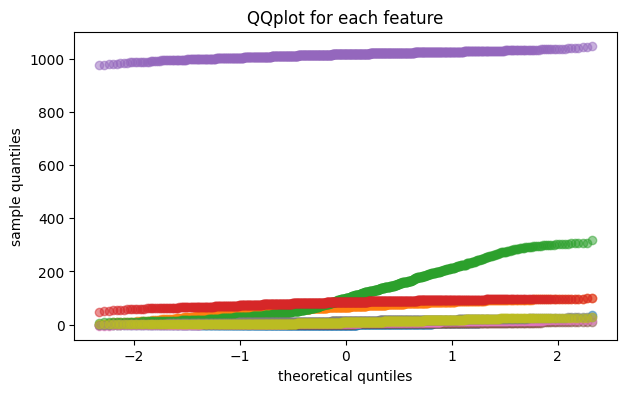

 shape of X_train after removing outliers:(694, 9)
 shape of y_train after removing outliers:(694,)


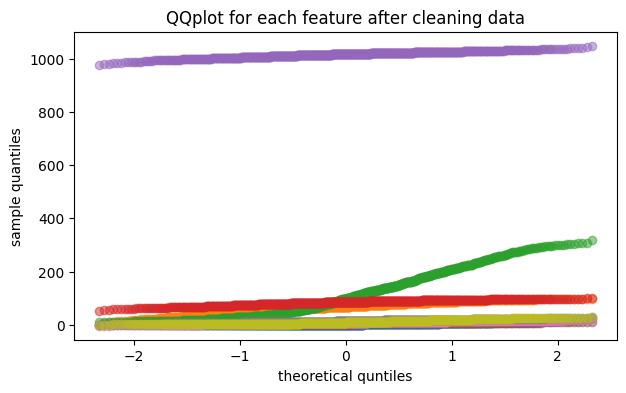

(694, 9)
(694,)


In [24]:
def visualise_handle_outliers(X_train, y_train):
    """
    detect and removes outliers from x_train using isolation forest,
    then visualize the data before handling and after handling outliers
    """

    iso_forest = IsolationForest(n_estimators=100, contamination = 0.05, random_state=42)
    outliers = iso_forest.fit_predict(X_train)



    #Now visualise outliers before handling them
    plt.figure(figsize=(7, 4))
    for column in X_train.columns:
        sorted_values = np.sort(X_train[column])
        theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_values)))
        plt.scatter(theoretical_quantiles, sorted_values, alpha=0.5)
        
    plt.title('QQplot for each feature')
    plt.xlabel('theoretical quntiles')
    plt.ylabel('sample quantiles')
    plt.grid(False)
    plt.show()

    X_train['outlier'] = outliers
    X_train_cleaned = X_train[X_train['outlier']==1].drop(columns=['outlier'])
    X_train_with_no_outliers_index = X_train_cleaned.index

    y_train_cleaned = y_train.loc[X_train_with_no_outliers_index]  # filter y_train to keep only rows corresponding to cleaned x_train

    print(f' shape of X_train after removing outliers:{X_train_cleaned.shape}')
    print(f' shape of y_train after removing outliers:{y_train_cleaned.shape}')


    #Now visualize QQplot after handling outliers
    plt.figure(figsize=(7, 4))
    for column in X_train_cleaned.columns:
        sorted_values = np.sort(X_train_cleaned[column])
        theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_values)))
        plt.scatter(theoretical_quantiles, sorted_values, alpha=0.5)
        
    plt.title('QQplot for each feature after cleaning data')
    plt.xlabel('theoretical quntiles')
    plt.ylabel('sample quantiles')
    plt.grid(False)
    plt.show()

    return X_train_cleaned, y_train_cleaned
    # remove outliers from our trining dataset
X_train_cleaned, y_train_cleaned = visualise_handle_outliers(X_train, y_train)
print(X_train_cleaned.shape)
print(y_train_cleaned.shape)



after removing outliers we see more consistent pattern in our train dataset. 

### Normalisation (fit_transform on train set -  transform on test set)

In [25]:
def Normalize_data(X_train, y_train, X_test, y_test):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # scaler fit_transform on train set
    X_test_scaled = scaler.transform(X_test)        # scaler only transform on test set to avoid data leaking

    df_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)  #convert X_train_scaled to dataframe
    df_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)      ##convert X_train_scaled to dataframe

    

    return df_train_scaled, df_test_scaled, y_train, y_test

X_train_scaled, X_test_scaled, y_train, y_test = Normalize_data(X_train_cleaned, y_train_cleaned, X_test, y_test) 


print(f'X_train_scaled shape:{X_train_scaled.shape}')
print(f'X_test_scaled shape:{X_test_scaled.shape}')
print(f'y_train shape:{y_train.shape}')
print(f'y_test shape:{y_test.shape}')
print(type(X_train_scaled))
print(type(X_test_scaled))
print(type(y_train))
print(type(y_test))


X_train_scaled shape:(694, 9)
X_test_scaled shape:(62, 9)
y_train shape:(694,)
y_test shape:(62,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Calculating VIF score to identify Multicollinearity

**Variance Inflation Factor(VIF)** is a statistical measure which can detect multicollinearity between independent variables(Sundus et al., 2022)
Sundus, K.I., Hammo, B.H., Al-Zoubi, M.B. and Al-Omari, A., 2022. 

paper : Solving the multicollinearity problem to improve the stability of machine learning algorithms applied to a 
fully annotated breast cancer dataset. Informatics in Medicine Unlocked, 33, p.101088.

from this paper, we decided to handle the multicollinearity problem which is when two or more features are highly correlated to each other. when one feature has high correlation with other feature, this means one of these features are enough in
our calculations and modeling and that feature can iterpret and predict the output itself. we can simply remove one feature. otherwise this can have negative effect on our prediction.

from correlation matrix we can see two variable **solar radiation** and **solar energy** has correlation of 1 which means 100% they can describe each other so one of them should be removed.
between these two, we look at correlation of each with **pv output** , whichever have high correlation with output that would be selected.the others would be discarded.

for better understanding the relationship and correlation between independent variables we only need to calculate VIF score



In [26]:
%pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
#function to calculate VIF score  for X_train_scaled

def calculate_vif(X):
    # create a dataframe to store vif scores
    vif_data = pd.DataFrame()
    vif_data['features'] = X.columns
    #calculate vif score for each features
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

vif_scores = calculate_vif(X_train_scaled)
print(f'vif scores are:{vif_scores}')
vif_scores



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
vif scores are:          features         VIF
0           precip    1.597353
1      cloud cover    2.282771
2  solar radiation  825.967610
3         humidity    2.970669
4         pressure    1.571957
5         UV index    8.599232
6         temp min    7.133647
7         temp max    9.471909
8     solar energy  842.810478


features         VIF
0           precip    1.597353
1      cloud cover    2.282771
2  solar radiation  825.967610
3         humidity    2.970669
4         pressure    1.571957
5         UV index    8.599232
6         temp min    7.133647
7         temp max    9.471909
8     solar energy  842.810478

#### X_train_scaled, X_test_scaled, y_train, y_test

In [27]:
print(f'X_train_scaled :\n\n{X_train_scaled}')
print(f'X_test_scaled :\n\n{X_test_scaled}')
print(f'y_train:\n\n{y_train}')
print(f'y_test:\n\n{y_test}')

X_train_scaled :

       precip  cloud cover  solar radiation  humidity  pressure  UV index  \
0   -0.624943     0.295776        -1.045867  0.409504  0.827314 -0.925894   
1   -0.593542    -1.309389        -0.740148 -0.174241  1.590714 -0.925894   
2   -0.624943    -0.340036        -0.865012 -0.108157  1.134536 -0.509722   
3   -0.599822    -2.091125        -0.848909  0.772968  0.482853 -0.509722   
4   -0.589878     0.983703        -1.063210  0.872095  0.361826 -0.925894   
..        ...          ...              ...       ...       ...       ...   
689  0.215841    -0.256651        -1.016138  0.200237 -1.416337 -0.925894   
690 -0.267486    -0.001284        -1.140011 -2.134744 -1.369788 -0.925894   
691 -0.619710    -0.543288        -0.873684 -1.297676 -0.559840 -0.509722   
692 -0.545915     0.671009        -1.094674  0.387476  0.054604 -0.925894   
693 -0.513729     1.233859        -1.074358  1.081362 -0.261927 -0.925894   

     temp min  temp max  solar energy  
0   -1.421353 -1.

### Feature Selection using correlation (Using the result from VIF score)


as we can see precip (1.59), cloud cover(2.28), humidity (2.97) pressure (1.57) dont show strong multicollinearity.
uv index (8.5), temp min(7.13), temp max (9.47) show moderate multicollinearity.
solar radiation (825.96) and solar energy (842.81) show very high multicollinearity. meaning these two feature are highly correlated and keeping both in model can cause instability.



from correlation matrix and vif score we can remove solar energy because it already includes solar radiation indirectly.keeping both can make our model unstable.
since temp min and temp max have multicollinearity and one of them are enough to describe the other , we drop one of them. in addition, uv index also has 0.93 correlation with solar energy and solar radiation.
so it would be sensible to drop uv index from our calculation.
from correlation we select 6 features out of nine.


basd on this **paper** :
**Fan, Y., Liu, J., Tang, J., Liu, P., Lin, Y. and Du, Y., 2024. Learning correlation information for multi-label feature selection. Pattern Recognition, 145, p.109899.**
one method for feature selection is feature selection based on correlation . in this method we measure correlation between independent variabled with each other. if two features have high correlation like solar energy and solar radiation one have to be discarded, because one already can describe the other .we dont need both of them.otherwise this can have negative effect on our modeling process.make our model unstable.





### 1- Feature Selection with Correlation (threshold=0.75)

In [29]:
def correlation_feature_selection(X_train, X_test, threshold = 0.75):

    corr_matrix = X_train.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    #dropp features with high correlation 
    features_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    print(f'features_to_drop:{features_to_drop}')
    X_train_corr = X_train.drop(columns=features_to_drop)
    X_test_corr = X_test.drop(columns=features_to_drop)

    return X_train_corr, X_test_corr

X_train_corr, X_test_corr = correlation_feature_selection(X_train_scaled.copy(), X_test_scaled.copy())

print(f'X_train_scaled shape:\n{X_train_scaled.shape}')
print(f'X_test_scaled shape:\n{X_test_scaled.shape}')
# print(f'X train_scaled:\n{X_train_scaled}')
# print(f'X_test_scaled:\n{X_test_scaled}')

print(f'X_train_corr :\n\n{X_train_corr}')
print(f'X_test_corr :\n\n{X_test_corr}')

features_to_drop:['UV index', 'temp max', 'solar energy']
X_train_scaled shape:
(694, 9)
X_test_scaled shape:
(62, 9)
X_train_corr :

       precip  cloud cover  solar radiation  humidity  pressure  temp min
0   -0.624943     0.295776        -1.045867  0.409504  0.827314 -1.421353
1   -0.593542    -1.309389        -0.740148 -0.174241  1.590714 -1.870297
2   -0.624943    -0.340036        -0.865012 -0.108157  1.134536 -1.151987
3   -0.599822    -2.091125        -0.848909  0.772968  0.482853 -1.398906
4   -0.589878     0.983703        -1.063210  0.872095  0.361826 -1.196881
..        ...          ...              ...       ...       ...       ...
689  0.215841    -0.256651        -1.016138  0.200237 -1.416337 -1.039751
690 -0.267486    -0.001284        -1.140011 -2.134744 -1.369788 -1.219328
691 -0.619710    -0.543288        -0.873684 -1.297676 -0.559840 -1.421353
692 -0.545915     0.671009        -1.094674  0.387476  0.054604 -1.847849
693 -0.513729     1.233859        -1.074358  1.08136

- Another method for feature selection that we applied is **Mutual Information**.
this method measures the dependency between features and target variables. The more informative a feature is about the target, the higher its
 mutual information score.
features with higher MI scores are more relevant to target variable.
the SelectKBest method picks the top k features based on MI scores

### Feature selection with Mutual Information 

X_train_mu_info:

     cloud cover  solar radiation  humidity  UV index  temp max  solar energy
0       0.295776        -1.045867  0.409504 -0.925894 -1.596540     -1.044784
1      -1.309389        -0.740148 -0.174241 -0.925894 -1.517247     -0.829920
2      -0.340036        -0.865012 -0.108157 -0.509722 -1.041490     -0.858569
3      -2.091125        -0.848909  0.772968 -0.509722 -1.299192     -0.858569
4       0.983703        -1.063210  0.872095 -0.925894 -0.744142     -1.059108
..           ...              ...       ...       ...       ...           ...
689    -0.256651        -1.016138  0.200237 -0.925894 -0.962197     -1.016136
690    -0.001284        -1.140011 -2.134744 -0.925894 -1.656009     -1.130730
691    -0.543288        -0.873684 -1.297676 -0.509722 -1.418131     -0.872893
692     0.671009        -1.094674  0.387476 -0.925894 -1.477600     -1.030460
693     1.233859        -1.074358  1.081362 -0.925894 -0.545910     -1.059108

[694 rows x 6 columns]

X_test_mu_info:

    

/tmp/ipykernel_5727/489309466.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores.index, y=feature_scores.values, palette='viridis')


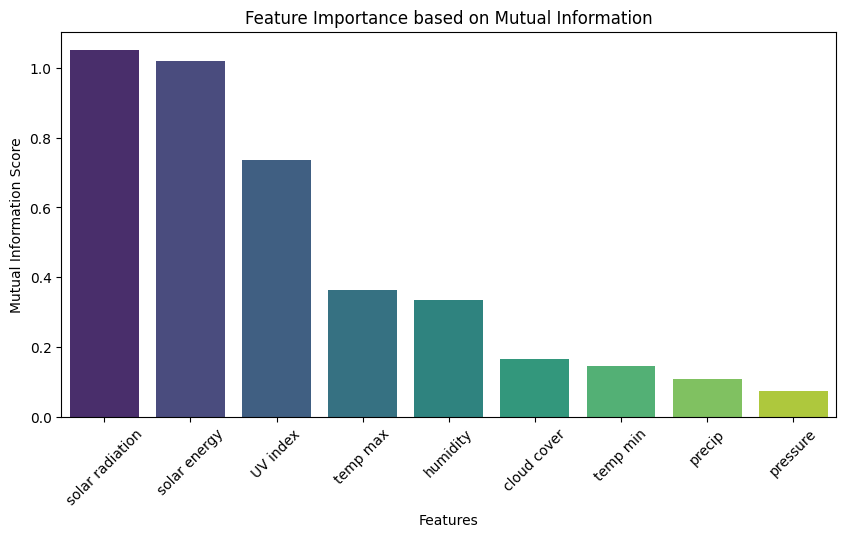

In [30]:
#define function for mutual information feature selection
def mutual_info_feature_selection(X_train, y_train, X_test, k= 5):


    feature_selector = SelectKBest(score_func=mutual_info_regression, k=k)  #initialise SelectKBest with mutual information

    feature_selector.fit(X_train, y_train)                                  # fit feature selector to training data

    selected_features = list(X_train.columns[feature_selector.get_support()])

    
    feature_scores = pd.Series(feature_selector.scores_, index=X_train.columns).sort_values(ascending=False) #get score for feature importance

    X_train_fs = pd.DataFrame(feature_selector.transform(X_train), columns=selected_features, index=X_train.index) #transform train and test data to have only selected features
    X_test_fs = pd.DataFrame(feature_selector.transform(X_test), columns=selected_features, index=X_test.index)
    # print(f'selected features :{selected_features}')
    # print(f'feature_scores :\n{feature_scores}')

    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_scores.index, y=feature_scores.values, palette='viridis')
    plt.xticks(rotation=45)
    plt.xlabel('Features')
    plt.ylabel('Mutual Information Score')
    plt.title('Feature Importance based on Mutual Information')
    # plt.show()




    return X_train_fs, X_test_fs


X_train_mu_info, X_test_mu_info = mutual_info_feature_selection(X_train_scaled.copy(), y_train.copy(), X_test_scaled.copy(), k=6)

print(f'X_train_mu_info:\n\n{X_train_mu_info}\n')
print(f'X_test_mu_info:\n\n{X_test_mu_info}')
print(type(X_train_mu_info))




Based on the result from Mutual Information Bar Plot, the top 6 features are selected based on their MI scores.
higher mi scores means strongest relationship with the target variable.
-according to graph, **solar radiation (1.05)** and **solar energy(1.02)** are the most important features, meaning have **highest** predictive power for the target.
- on the other hand **precipitation** and **pressure** are **lowest** MI score, meaning weak dependency with target variable.



Another feature selection method that we utilized is **PCA**

### Feature Selection with PCA

shape of X_train_pca:(694, 5)
shape of X_test_pca:(62, 5)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


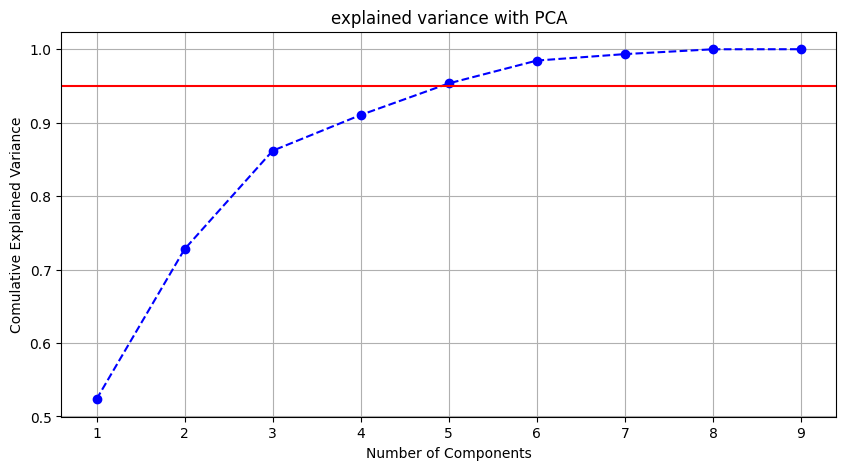

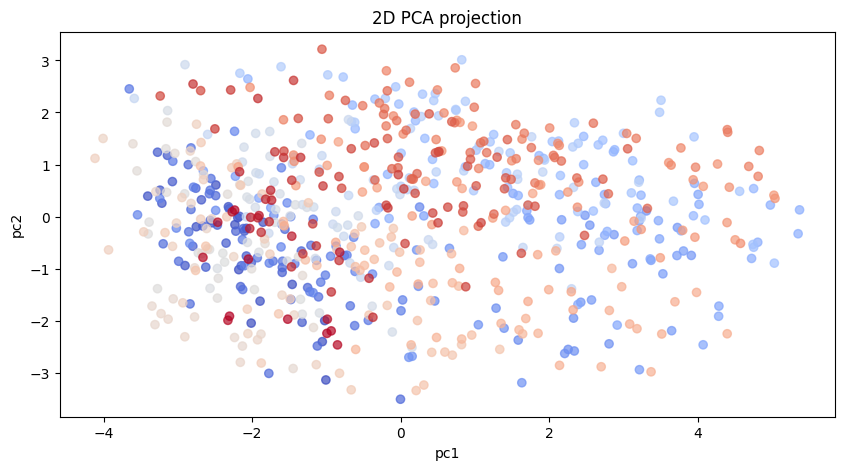

In [33]:
def pca_feature_selection(X_train, X_test, variance_threshold=0.95):

    pca = PCA()   # initialise pca

    X_train_pca = pca.fit_transform(X_train)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    # print(f"explained variance:{explained_variance}")

    # now we need to find the minimum number of components to reach the variance threshols
    n_components = np.argmax(explained_variance >= variance_threshold) + 1
    # print(f'pca selected {n_components} that can explain {variance_threshold} * 100')

    # now we apply pca with the best number of components
    pca = PCA(n_components=n_components)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)

    pca_columns = [f"pc{i+1}" for i in range(n_components)]

    X_train_pca_df = pd.DataFrame(X_train_reduced, index=X_train.index, columns=pca_columns)
    X_test_pca_df = pd.DataFrame(X_test_reduced, index=X_test.index, columns=pca_columns)


    #we visualise explained variance
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker= 'o', linestyle= '--', color='b')
    plt.axhline(y=variance_threshold, color='r', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Comulative Explained Variance')
    plt.title('explained variance with PCA')
    plt.grid(True)
    # plt.show()


    # if we want to visualise pca with atleast to components
    if n_components >= 2:
        plt.figure(figsize=(10, 5))
        plt.scatter(X_train_reduced[:,0], X_train_reduced[:,1], alpha=0.7, c=np.arange(len(X_train_reduced)), cmap='coolwarm')
        plt.xlabel('pc1')
        plt.ylabel('pc2')
        plt.title('2D PCA projection')
        # plt.show()
    
    


    return X_train_pca_df, X_test_pca_df

X_train_pca, X_test_pca = pca_feature_selection(X_train_scaled.copy(), X_test_scaled.copy(), variance_threshold=0.95)

print(f'shape of X_train_pca:{X_train_pca.shape}')
print(f'shape of X_test_pca:{X_test_pca.shape}')
print(type(X_train_pca))
print(type(X_test_pca))






Explained Variance with PCA:
this graph shows when selecting 5 principle components, 95% of variance will be explained.

2D PCA Projection:
this graph shows dimentionality reduction technique, that compresses the information from high dimentional data into two main components.
red dots corresponds to higher values of dependent variable like solar radiation, solar energy,...
blue dots correspond to lower value.

### Distribution of target variable

since this is regression problem it is good to practice Histogram or kde plot to check distribution of target variables:


 mean of PV output:2.9513
 median of PV output:2.7585
standard deviation:2.0028
min value of PV output:0.0780, max value:6.8700


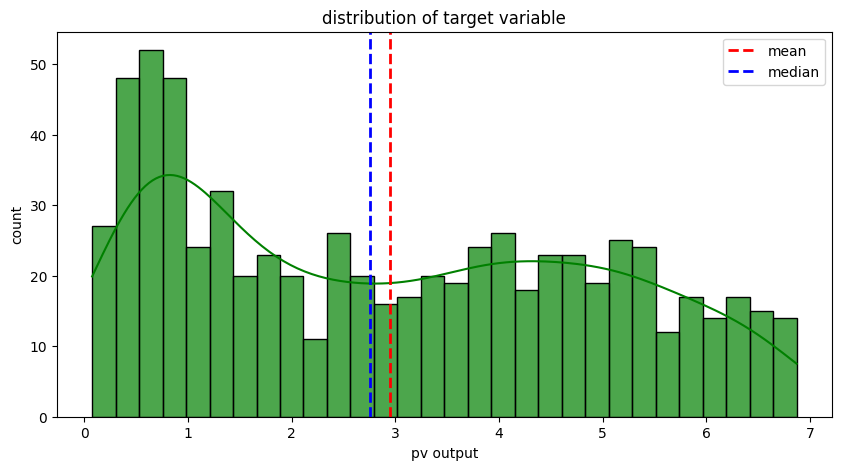

In [34]:
def check_target_distribution(y_train):
    """ 
    we want to check distibution of target variable in regression problem. for this we utilze statistics and visualization

    """
    #first we check some basic statistics
    print(f' mean of PV output:{y_train.mean():.4f}')
    print(f' median of PV output:{y_train.median():.4f}')
    print(f'standard deviation:{y_train.std():.4f}')
    print(f'min value of PV output:{y_train.min():.4f}, max value:{y_train.max():.4f}')

    #plot histogram and kde plot to visualise the distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(y_train, bins=30, kde=True, color='green', alpha=0.7)
    plt.axvline(y_train.mean(), color='red', linestyle='dashed', linewidth=2, label='mean')
    plt.axvline(y_train.median(), color='blue', linestyle='dashed', linewidth=2, label='median')
    plt.legend()
    plt.title('distribution of target variable')
    plt.xlabel('pv output')
    plt.ylabel('count')
    plt.show()

check_target_distribution(y_train)

In [ ]:
this graph shows multimodal distribution because there is more than one peak, which means the target variable influences by different conditions.

## Building Models

features_to_drop:['UV index', 'temp max', 'solar energy']
best parameteres Decision Tree: {'max_depth': 10}
best parameteres RandomForest: {'max_depth': 20, 'n_estimators': 50}
best parameteres KNN Regressor: {'n_neighbors': 10}
best parameteres AdaBoost: {'n_estimators': 50}
best parameteres XGBoost: {'learning_rate': 0.1, 'n_estimators': 50}
best parameteres Linear Regression: {}
selected features :['solar radiation', 'humidity', 'UV index', 'temp max', 'solar energy']
feature_scores :
solar radiation    1.051119
solar energy       1.028590
UV index           0.736102
temp max           0.365506
humidity           0.330976
cloud cover        0.164821
temp min           0.145952
precip             0.107244
pressure           0.077769
dtype: float64


/tmp/ipykernel_1413/220992288.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_scores.index, y=feature_scores.values, palette='viridis')


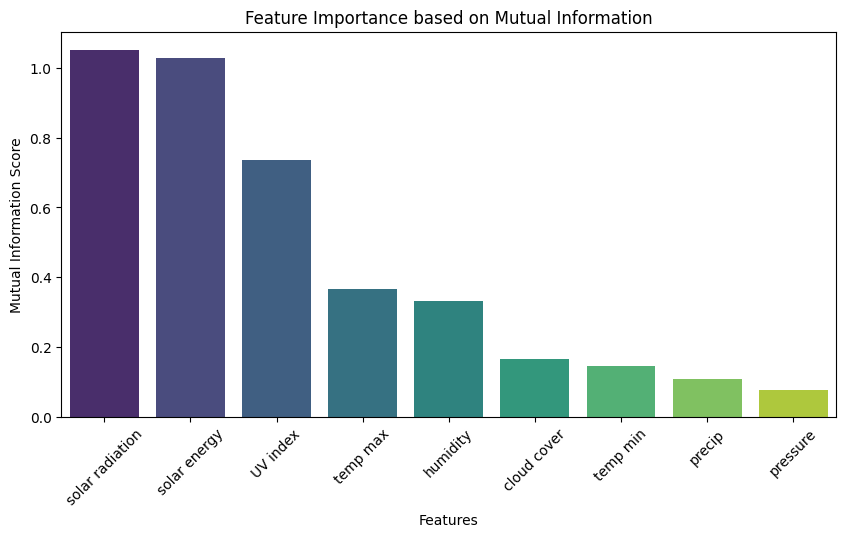

/usr/local/lib/python3.12/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best parameteres Decision Tree: {'max_depth': 20}
best parameteres RandomForest: {'max_depth': 10, 'n_estimators': 50}
best parameteres KNN Regressor: {'n_neighbors': 10}
best parameteres AdaBoost: {'n_estimators': 50}
best parameteres XGBoost: {'learning_rate': 0.1, 'n_estimators': 50}
best parameteres Linear Regression: {}
explained variance:[0.52338768 0.72774141 0.86175111 0.91046097 0.95347481 0.98455029
 0.99336965 0.99993318 1.        ]
pca selected 5 that can explain 0.95 * 100


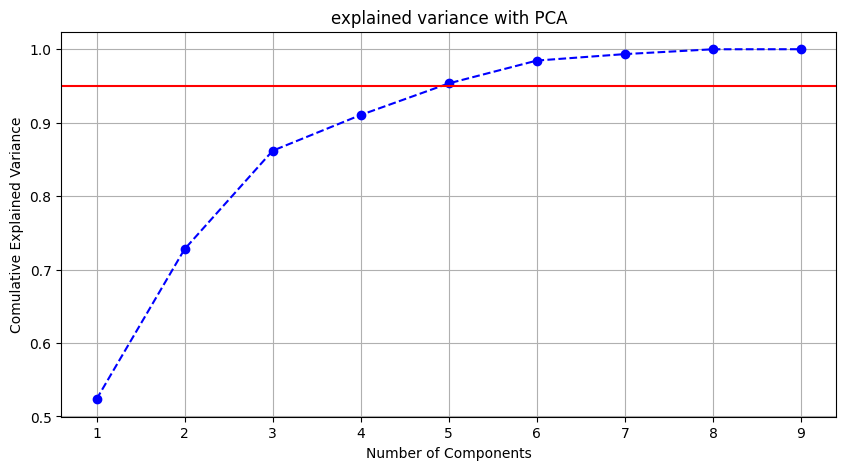

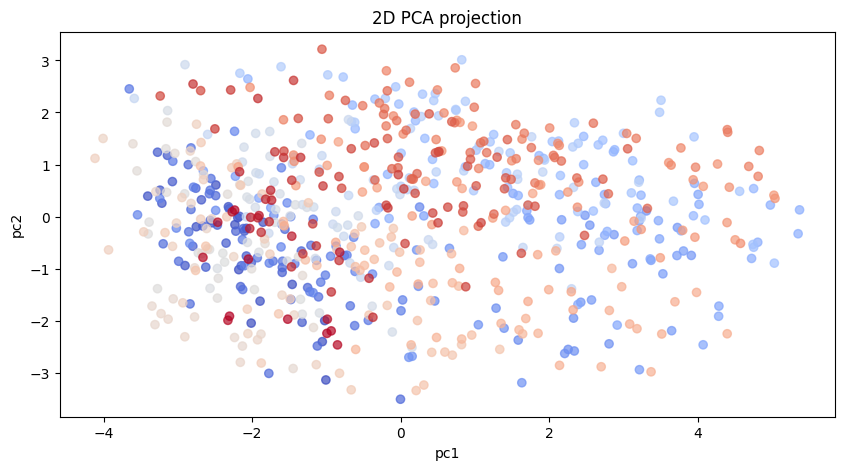

/usr/local/lib/python3.12/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best parameteres Decision Tree: {'max_depth': 10}
best parameteres RandomForest: {'max_depth': 10, 'n_estimators': 100}
best parameteres KNN Regressor: {'n_neighbors': 10}
best parameteres AdaBoost: {'n_estimators': 50}
best parameteres XGBoost: {'learning_rate': 0.1, 'n_estimators': 50}
best parameteres Linear Regression: {}

final results

:                    correlation                                     \
                  R2 score Test       MAE       MSE R2_score_train   
Decision Tree         -0.112050  0.275191  0.141182       0.989225   
RandomForest           0.459155  0.214019  0.068664       0.984293   
KNN Regressor         -0.816185  0.391015  0.230576       0.894299   
AdaBoost              -0.330284  0.333674  0.168888       0.905052   
XGBoost                0.228369  0.247671  0.097963       0.985024   
Linear Regression     -0.301076  0.315972  0.165180       0.876849   

                  mutual information                                     \
                   

In [62]:
def train_evaluate_grid_search(X_train, X_test, y_train, y_test, feature_selection_method):
    models={

        "Decision Tree": DecisionTreeRegressor(),
        "RandomForest": RandomForestRegressor(),
        "KNN Regressor":KNeighborsRegressor(),
        "AdaBoost": AdaBoostRegressor(),
        "XGBoost":XGBRegressor(),
        "Linear Regression":LinearRegression(),
        
    }

    param_grid = {

        "Ridge Regression": {"alpha":[0.1, 1, 10]},
        "Lasso Regression": {"alpha":[0.1, 1, 10]},
        "Decision Tree": {"max_depth":[10, 20]},
        "RandomForest":{"n_estimators":[50, 100], "max_depth":[10, 20]},
        "KNN Regressor":{"n_neighbors":[10]},
        "AdaBoost":{"n_estimators":[50, 100]},
        "XGBoost":{"n_estimators":[50, 100], "learning_rate":[0.01, 0.1]},
        "Linear Regression":{}
    }

    results = {}

    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grid.get(name, {}), cv=3, scoring="r2", verbose=0)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        r2_test = r2_score(y_test, y_pred)
        r2_train = r2_score(y_train, y_pred_train)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        results[name] = {"R2 score Test": r2_test, "MAE": mae, "MSE":mse, "R2_score_train":r2_train }
        print(f"best parameteres {name}: {grid_search.best_params_}")
    return pd.DataFrame(results).T

all_results = {}   


#feature selection with correlation
X_train_corr, X_test_corr = correlation_feature_selection(X_train_scaled.copy(), X_test_scaled.copy(), threshold=0.75) 
results_with_corr = train_evaluate_grid_search(X_train_corr, X_test_corr, y_train, y_test, "correlation_based feature selection")
all_results["correlation"] = results_with_corr



# #feature selection with mutual information
X_train_mu_info, X_test_mu_info = mutual_info_feature_selection(X_train_scaled.copy(), y_train, X_test_scaled.copy(), k=5)
results_with_mi = train_evaluate_grid_search(X_train_mu_info, X_test_mu_info, y_train, y_test, "mutual information feature selection")
all_results["mutual information"] = results_with_mi



# #feature selection with PCA
X_train_pca, X_test_pca = pca_feature_selection(X_train_scaled.copy(), X_test_scaled.copy(), variance_threshold=0.95)
results_with_pca =  train_evaluate_grid_search(X_train_pca, X_test_pca, y_train, y_test, "pca feature selection") 
all_results["PCA"] = results_with_pca





final_results = pd.concat(all_results, axis=1)
print(f'\nfinal results\n\n:{final_results from machine learning models}')


### Result from Machine Learning Models



from the result we can see that

in **correlation** feature selection the best models are **Random Forest** with **R2score test(0.45)**, **MAE(0.21)**, and **MSE(0.06)**.

the second best model is **XGBoost** with **R2 score(0.23)**, **MAE(0.24)**, and **MSE (0.09)**.







in **mutual information** technique for the best model is **XGBoost** with **R2 score test(0.50)**,  **MAE(0.21)**, and **MSE(0.06)**.

the second best model is **KNN Regressor** with **R2 score(0.47)**, **MAE(0.20)**, and **MSE (0.06)**.

the third best model is **RandomForest** with **R2 score(0.37)**, **MAE(0.21)**, and **MSE (0.07)**.





in **PCA** feature selection the best models are **Random Forest** with **R2score test(0.42)**, **MAE(0.20)**, and **MSE(0.07)**.

the second best model is **KNN Regressor** with **R2 score(0.30)**, **MAE(0.24)**, and **MSE (0.08)**.

in the same thechnique the third best model is **XGBoost** with **R2 score test(0.18)**,  **MAE(0.24)**, and **MSE(0.10)**.



## Build CNN-LSTM Model

Result from machine learning models, indicate that while some models, like XGBoost, KNN Regressor, and RandomForest, achieve reasonable performance, 
the other models with negative R2 score,performed significantly worse, indicating poor generalization, particularly in effectively capturing the Non-linear relationship,and temporal dependencies in output predictions.

based on my our research to exploring deep learning models, we came across this paper from 2022:
**Agga, A., Abbou, A., Labbadi, M., El Houm, Y. and Ali, I.H.O., 2022. CNN-LSTM: An efficient hybrid deep learning architecture for predicting short-term photovoltaic power production. Electric Power Systems Research, 208, p.107908.**


This paper introduce a Hybrid model CNN-LSTM for pv output prediction because it combines spatial and temporal feature extraction which is limitations of traditional machine learning models.

**CNN** : extracts spatial pattern in data identifying key featuresfrom weather related inputs (solar radiation, temperature , ...)

**LSTM** (Long Short Term Memory) capture temporal dependencies, learning patterns in pv output fluctuation over time.

**Hybrid Advantage** : CNN improves feature extraction, while LSTM enhances sequential learning, making the model more stable. 





we train model CNN-LSTM to see whether deep learning model can better capture the underlying patterns in dataset compared to machine learning models.

if CNN-LSTM can show better generalization and low error, it confirms that deep learning is better fit for this dataset. 


Epoch1/ 80, loss:5.7899
Epoch2/ 80, loss:3.9611
Epoch3/ 80, loss:2.0966
Epoch4/ 80, loss:0.7643
Epoch5/ 80, loss:0.5561
Epoch6/ 80, loss:0.5965
Epoch7/ 80, loss:0.4876
Epoch8/ 80, loss:0.4627
Epoch9/ 80, loss:0.4736
Epoch10/ 80, loss:0.4278
Epoch11/ 80, loss:0.4354
Epoch12/ 80, loss:0.4042
Epoch13/ 80, loss:0.4413
Epoch14/ 80, loss:0.4122
Epoch15/ 80, loss:0.3974
Epoch16/ 80, loss:0.4118
Epoch17/ 80, loss:0.3833
Epoch18/ 80, loss:0.3786
Epoch19/ 80, loss:0.4109
Epoch20/ 80, loss:0.3853
Epoch21/ 80, loss:0.3841
Epoch22/ 80, loss:0.3739
Epoch23/ 80, loss:0.3928
Epoch24/ 80, loss:0.4176
Epoch25/ 80, loss:0.3766
Epoch26/ 80, loss:0.4180
Epoch27/ 80, loss:0.3482
Epoch28/ 80, loss:0.3470
Epoch29/ 80, loss:0.3351
Epoch30/ 80, loss:0.3567
Epoch31/ 80, loss:0.3503
Epoch32/ 80, loss:0.3557
Epoch33/ 80, loss:0.3420
Epoch34/ 80, loss:0.3293
Epoch35/ 80, loss:0.3472
Epoch36/ 80, loss:0.3208
Epoch37/ 80, loss:0.3409
Epoch38/ 80, loss:0.3301
Epoch39/ 80, loss:0.3379
Epoch40/ 80, loss:0.3087
Epoch41/ 

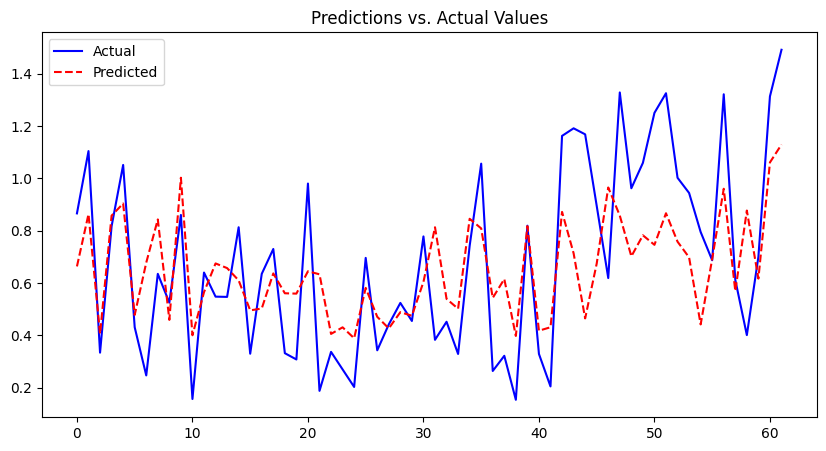

In [75]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



def preprocess_for_cnn_lstm(X_train, X_test, y_train, y_test):  # function for preprocess for cnn-lstm
    
    #first we need to convert dataframe to numpy array
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy() 
    y_train_np = y_train.to_numpy().reshape(-1, 1)
    y_test_np = y_test.to_numpy().reshape(-1, 1)

    #now reshape xtrain and xtest to 3D for cnn-lstm (samples, time steps, features)
    X_train_reshaped = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
    X_test_reshaped = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))

    X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)         #convert numpy array to pytorch tensors
    X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

   
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)     #create pytorch dataset and dataloader for batching
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False )
    return train_loader, test_loader, X_train_tensor.shape[2]
    


class CNN_LSTM(nn.Module):                                       #define cnn-lstm model in pytorch

    
    def __init__(self, input_dim):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.pool = nn.AdaptiveAvgPool1d(output_size=1)   #pooling layer to reduce feature map size
        
        self.flatten = nn.Flatten()                       #flatten layer to reshape cnn output for lstm input
        #
        # lstm layers for learning temporal dependencies
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=16, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=16, hidden_size=32, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        
        self.dropout = nn.Dropout(0.2)     #dropout layer to prevent overfitting

        self.fc1 = nn.Linear(64, 100)  # first dense layer
        self.fc2 = nn.Linear(100, 1)   # last output layer
        self.relu = nn.ReLU()   #activation function
        
    def forward(self, x):
        
        batch_size, time_steps, features = x.size()
        x = x.view(batch_size*time_steps, 1, features)   #reshape input for cnn
        
        x = self.relu(self.conv1(x))   #apply convolutional layer  with relu activation 
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        # print(x.shape)
        x = self.pool(x)
        x = self.flatten(x)  #flatten for lstm input

        x = x.view(batch_size, time_steps, -1)                   #reshape for lstm (batch_size, time_steps, -1) layer

        x, _ = self.lstm1(x)   # apply lstm layer sequentially
        x,_ = self.lstm2(x)
        x,_ = self.lstm3(x)


        x = x[:,-1,:]
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


train_loader, test_loader, input_dim = preprocess_for_cnn_lstm(X_train_scaled, X_test_scaled, y_train, y_test)

model = CNN_LSTM(input_dim)                                    #initialize the CNN-LSTM model
criterion = nn.MSELoss()     #define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)
        
num_epochs=80
device = torch.device("cuda" if torch.cuda.is_available else "cpu")  # check if gpu is available
model.to(device)

#training loop
for epoch in range(num_epochs):
    model.train()   #set model for training mode
    running_loss=0.0    #set loss counter
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)   # move data to gpu
        optimizer.zero_grad()
        outputs = model(inputs)   #forward pass
        
        loss = criterion(outputs, targets)  #compute loss
        loss.backward()   #backpropagation
        optimizer.step()   #update weights
        running_loss += loss.item() * inputs.size(0)  #accumulate loss
    epoch_loss = running_loss / len(train_loader.dataset)  # compute average loss for epoch
    print(f'Epoch{epoch + 1}/ {num_epochs}, loss:{epoch_loss:.4f}')


model.eval()   #model evaluation on test set
predictions = []
actuals = []
test_loss = 0.0


# disable gradient computation for evaluation
with torch.no_grad():    
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)                     #get model predictions
        predictions.extend(outputs.cpu().numpy())   # store predictions
        actuals.extend(targets.cpu().numpy())        # store actual values
        
        loss = criterion(outputs, targets)           # get test loss
        test_loss += loss.item() * inputs.size(0)
test_loss /= len(test_loader.dataset)
print(test_loss)

predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()

mse = mean_squared_error(actuals, predictions)  #mean squared error
rmse = np.sqrt(mse)                             # root mean squared error
r2 = r2_score(actuals, predictions)              # r2 score

print(f"model evaluations:")
print(f"mean squared error:{mse:.4f}")
# print(f"root mean squared error:{rmse:.4f}")
print(f"r2 score:{r2:.4f}")

plt.figure(figsize=(10, 5))                       # plot actual vs predicted values
plt.plot(actuals, label="Actual", linestyle="solid", color='blue')
plt.plot(predictions, label="Predicted", linestyle="dashed", color='red')
plt.legend()
plt.title("Predictions vs. Actual Values")
plt.show()




## Build Transformer Model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from icecream import ic 
from tqdm import tqdm 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score
from torch.utils.tensorboard import SummaryWriter



In [37]:
writer = SummaryWriter('./runs/Danucore_Recruitment.ipynb')

torch.Size([694, 9]) torch.Size([694]) torch.Size([62, 9]) torch.Size([62])


Train loss: 0.34 Test loss: 0.05 R2 Train: 0.92 R2 Test: 0.6: 100%|██████████████████████████████████████████████████████████████| 300/300 [03:38<00:00,  1.37it/s]


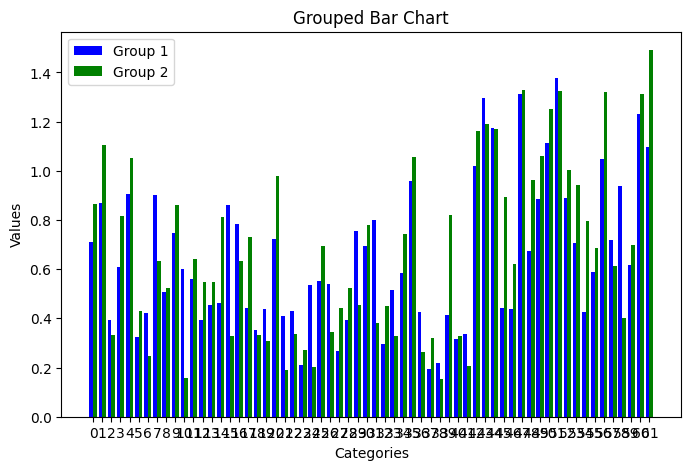

In [48]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import csv

from icecream import ic
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from torch.utils.tensorboard import SummaryWriter




writer = SummaryWriter('runs/Danucore_Recruitment.ipynb')   # initialize tensorboard  for logging training metrics

class Transformer(nn.Module):
    """
    define transformer model
    -using a linear layer for initial feature projection
    -a transform encoder to learn complex dependencies
    -a final linear layer for output prediction

    """
    def __init__(self, embed_dim=256, num_heads=4, num_layers=12):  # embed_dim dimension of embedding layer / #num_heads number of attention heads/ num_layers number of transformer encoder layer
        
        super(Transformer, self).__init__()
        self.proj = nn.ModuleList([nn.Linear(9, embed_dim) for _ in range(9)])  # projection layer to transform input layer into high dimensional space
        self.encoder = nn.TransformerEncoder(                                   # transformer encoder
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True),
            num_layers=num_layers,
            
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)   #classification token
        self.linear = nn.Linear(embed_dim, 1)
        

    def forward(self, x):
        x = torch.stack([self.proj[i](x) for i in range(9)], dim=1)            # project each feature
        x = torch.cat([self.cls_token.expand(x.shape[0], -1, -1), x], dim=1)   # append cls token
        x = self.encoder(x)                                                    # transformer encoding
        x = x[:, 0]                                                            # extract cls token output
        x = self.linear(x).squeeze(-1)                                         # final linear layer for regression
        return x
    




def plot_barchart_grouped(data, labels):
    categories = np.arange(len(data))
    x = np.arange(len(categories))

    # Bar width
    bar_width = 0.4  

    plt.figure(figsize=(8, 5))
    plt.bar(x - bar_width/2, data, width=bar_width, color='blue', label='Group 1')   # bar chart for predictions
    plt.bar(x + bar_width/2, labels, width=bar_width, color='green', label='Group 2')   #bar 

    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title('Grouped Bar Chart')
    plt.xticks(x, categories)
    plt.legend()

    plt.savefig('grouped_bar_chart.png')




def main(X_train_scaled, X_test_scaled, y_train, y_test ):      #main training loop for transformer model
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #convert numpy array to pytorch tensors and move to device
    X_train_tensor = torch.tensor(X_train_scaled.values).float().to(device)
   
    y_train_tensor = torch.tensor(y_train.values).float().to(device)
    
    X_test_tensor = torch.tensor(X_test_scaled.values).float().to(device)
    
    y_test_tensor = torch.tensor(y_test.values).float().to(device)

    print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)

    
    model = Transformer(embed_dim=1024, num_heads=2, num_layers=24).to("cuda")  # initialize transformer model
    
    model.train()    #train loop
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)#, weight_decay=1e-5)   # define optimizer and learning rate schedulers
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9, )
    for i in (pbar := tqdm(range(300))):          # training for 300 iteration
        
        optimizer.zero_grad()
        inp_data = X_train_tensor
        output = model(inp_data)                    # forward pass
        loss = F.mse_loss(output, y_train_tensor)   # calculate mse loss
        loss.backward()                             # backpropagation
        optimizer.step()                            # update weights
        
        r2 = r2_score(y_train_tensor.detach().cpu().numpy(), output.squeeze(-1).detach().cpu().numpy())   # compute r2 score
        writer.add_scalar("r2", r2, i)             # log metrics to tensorboard
        writer.add_scalar("train/loss", loss.item(), i)
        loss_val = round(loss.item(), 2)
        r2_val = round(r2, 2)

        model.eval()                              # validation loop
        
        with torch.no_grad():
            output = model(X_test_tensor)
            test_loss = F.mse_loss(output, y_test_tensor)
               
        r2_test = r2_score(y_test_tensor.detach().cpu().numpy(), output.squeeze(-1).detach().cpu().numpy())
        writer.add_scalar("test/loss", test_loss.item(), i)   # log validation metrics
        writer.add_scalar("r2_test", r2_test, i)
        test_loss_val = round(test_loss.item(), 2)
        r2_test_val = round(r2_test, 2)
        model.train()

            
            
            
            
        pbar.set_description(f"Train loss: {loss_val} Test loss: {test_loss_val} R2 Train: {r2_val} R2 Test: {r2_test_val}")
            
            
        
        
        # if lr_scheduler.get_last_lr()[0] > 1e-8:  # reduce learning rate after 100 iteration
        #     lr_scheduler.step()
        # writer.add_scalar("lr", lr_scheduler.get_last_lr()[0], i)


    model.eval()                                     # finall evaluation for test data
    with torch.no_grad():
        predictions = model(X_test_tensor)
    output = predictions.detach().cpu().numpy()
    test_labels = y_test_tensor.detach().cpu().numpy()
    plot_barchart_grouped(output, test_labels)    #plot predictions vs actual value
    
    

if __name__ == "__main__":
    
    main(X_train_scaled, X_test_scaled, y_train, y_test)


## Analysing the result from ML Models, CNN-LSTM Hybrid model, and Transformer model

machine learning models relies on manual feature selection, and struggle with time-series forcasting, because they can not inherently model temporal dependencies. given the irregular and fluctuating nature of photovoltaic (pv) power generation, ML models fail to capture complex trends accurately. so while **ML models** can give us a **baseline**, theyfail to capture long-range dependencies in time-series data.

to improve on ML models, we build a **CNN-LSTM hybrid model** based on insight from recent research (agga et al., 2022).
in this architecture CNN captures spatial patterns from weather related input (humidity, solar radiation, ...)
LSTM is known for captures temporal dependencies intime-series data by keeping memory for past observations. CNN-LSTM performed almost similar to best ML model (XGBOOST), but struggle with long-term dependencies.

until we built a **transformer model**

unlike CNN-LSTM and ML models, transformers has a **self-attention mechanism** to capture relationship between distant time steps, leading to better forcasting accuracy.
 LSTM sequence the process step by step,making the training process slow, but transformers process all time steps at once, allowing faster training.

 traditional models focus on local patterns but transformers pay attention to all sequence at once.

 **in this task the R2 score from transformer model is 0.6 (60%)  with test loss of (0.05 ) which outperform other models.**



## Analyse the Grouped Bar Chart

In the grouped bar chart, the x-axis represent the data points which is test data and the y-axis represent predicted and actual values.
Blue bars (group 1) represent models predictions.
Green bars(group 2) represent actual values.
so for each test sample one blue bar is prediction and one green bar is actual value.

if the blue bars(predictions) are close to green bars(actual values) the model is performing well.
if there is large difference between them it means model is making inaccurate predictions.


## Q2 - Extracting data using LLMs

The accompanying PDF file is a data sheet that gives specifications for a number of hardware products available from GivEnergy. Use an open source Large Language Model of your choice to run inference optimally on a single or multi-node cluster to extract the data from this pdf to the best of its ability. Please provide a record of the prompts you use in your interaction with the LLM.



the single node cluster is the best choice for me because currently I can handle LLM inference and text extraction on  AWS server.

for doing this task and running Large Language Model, I set up  clous-based environment using **AWS server** and build a **docker container** and used 
**Tmux** to run and interact with different language models via **Ollama**.
this is break down of my workflow:

first I used official Ollama website to get the latest version of Ollama, and run this command inside my docker container:

curl -fsSL https://ollama.com/install.sh | sh

I used Ollama because Ollama is an open source framework, that enables easy downloading, running and interacting with many large language models like
deepseek-r1, mistral, llama3.1, llama3.2, qwen,... locally or on the server.
Ollama provides lightweight API for serving models efficiently and support many language models.

since I needed to run multiple long-running processes such as serving the model in background, pulling model, and running jupyterlab, I used **Tmux**
**(Terminal Multiplexer)**
Tmux allows me to manage multiple terminal sessions within a single SSH connection. so that I can attach and detach from one session to another without 
interuption.

**Tmux Workflow**:
first I create a new session for serving the model:
in terminal inside the docker container I type:

**tmux new-session -s ollama-serve**
inside the session I run following command:

**ollama serve**

to detach from this session without stopping the process I press
**ctrl B + D**

Next, we start a new session to pull desired  language model:
**tmux new-session -s pull-llama3.2**
then the session is present for pulling our language model
in the session we run one of these following command (our desired language model):

**ollama pull llama3.2**

**ollama pull mistral**

**ollama pull deepseek-r1**

again for detach ctrlB + D

Now we set up and prepare our infrustructure to use language model and start to get the task done
the final command in terminal :

**jupyter lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root**




!ollama list


NAME               ID              SIZE      MODIFIED       
llama3.1:latest    46e0c10c039e    4.9 GB    14 minutes ago    


In [1]:
! ollama pull llama3.1

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling manifest     ▏    0 B/4.9 GB                  
pulling manifest     ▏    0 B/4.9 GB                  
pulling manifest     ▏ 6.4 MB/4.9 GB                  
pulling manifest     ▏  86 MB/4.9 GB                  
pulling manifest     ▏ 131 MB/4.9 GB                  
pulling manifest     ▏ 219 MB/4.9 GB                  
pulling manifest     ▏ 264 MB/4.9 GB                  
pulling manifest     ▏ 353 MB/4.9 GB                  
pulling manifest     ▏ 443 MB/4.9 GB                  
pulling manifest     ▏ 489 MB/4.9 GB                  
pulling manifest     ▏ 580 MB/4.9 GB  580 MB/s      7s
pulling manifest     ▏ 669 MB/4.9 GB  580 MB/s      7s
pulling manifest     ▏ 760 MB/4.9 GB  580 MB/s      7s
pulling manifest     ▏ 805 MB/4.9 GB  580 MB/s      7s
pulling manifest     ▏ 896 MB/4.9 GB  580 MB/s      6s
pulling manifest     ▏ 9

In [2]:
! ollama pull llama3.2

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest 
pulling dde5aa3fc5ff... 100% ▕████████████████▏ 2.0 GB                         
pulling 966de95ca8a6... 100% ▕████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da... 100% ▕████████████████▏ 7.7 KB                         
pulling a70ff7e570d9... 100% ▕████████████████▏ 6.0 KB                         
pulling 56bb8bd477a5... 100% ▕████████████████▏   96 B                         
pulling 34bb5ab01051... 100% ▕████████████████▏  561 B                         
verifying sha256 digest 
writing manifest ⠋ pulling manifest 
pulling dde5aa3fc5ff... 100% ▕████████████████▏ 2.0 GB                         
pulling 966de95ca8a6... 100% ▕████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da... 100% ▕████████████████▏ 7.7 KB                         
pulling a70ff7e570d9... 100% ▕████████████████▏ 6.0 KB                         
pulling 56bb8bd477a5... 100% ▕████████████████▏   96 B         

In [3]:
! ollama pull deepseek-r1

pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling manifest     ▏    0 B/4.7 GB                  
pulling manifest     ▏    0 B/4.7 GB                  
pulling manifest     ▏    0 B/4.7 GB                  
pulling manifest     ▏  42 MB/4.7 GB                  
pulling manifest     ▏ 125 MB/4.7 GB                  
pulling manifest     ▏ 170 MB/4.7 GB                  
pulling manifest     ▏ 261 MB/4.7 GB                  
pulling manifest     ▏ 351 MB/4.7 GB                  
pulling manifest     ▏ 398 MB/4.7 GB                  
pulling manifest     ▏ 486 MB/4.7 GB                  
pulling manifest     ▏ 578 MB/4.7 GB  578 MB/s      7s
pulling manifest     ▏ 622 MB/4.7 GB  578 MB/s      7s
pulling manifest     ▏ 712 MB/4.7 GB  578 MB/s      6s
pulling manifest     ▏ 803 MB/4.7 GB  578 MB/s      6s
pulling manifest     ▏ 849 MB/4.7 GB  578 MB/s      6s
pulling manifest     ▏ 940 MB/4.7 GB  578 M

In [5]:
! ollama pull mistral

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling manifest     ▏    0 B/4.1 GB                  
pulling manifest     ▏ 1.7 MB/4.1 GB                  
pulling manifest     ▏  17 MB/4.1 GB                  
pulling manifest     ▏  95 MB/4.1 GB                  
pulling manifest     ▏ 181 MB/4.1 GB                  
pulling manifest     ▏ 224 MB/4.1 GB                  
pulling manifest     ▏ 313 MB/4.1 GB                  
pulling manifest     ▏ 402 MB/4.1 GB                  
pulling manifest     ▏ 446 MB/4.1 GB                  
pulling manifest     ▏ 534 MB/4.1 GB                  
pulling manifest     ▏ 622 MB/4.1 GB  582 MB/s      5s
pulling manifest     ▏ 668 MB/4.1 GB  582 MB/s      5s
pulling manifest     ▏ 756 MB/4.1 GB  582 MB/s      5s
pulling manifest     ▏ 845 MB/4.1 GB  582 MB/s      5s
pulling manifest     ▏ 888 MB/4.1 GB  582 MB/s      5s
pulling manifest     ▏ 9

In [6]:
import requests
response = requests.get("http://localhost:11434/api/tags")
print(response.json())



{'models': [{'name': 'mistral:latest', 'model': 'mistral:latest', 'modified_at': '2025-02-18T10:10:52.69167753Z', 'size': 4113301824, 'digest': 'f974a74358d62a017b37c6f424fcdf2744ca02926c4f952513ddf474b2fa5091', 'details': {'parent_model': '', 'format': 'gguf', 'family': 'llama', 'families': ['llama'], 'parameter_size': '7.2B', 'quantization_level': 'Q4_0'}}, {'name': 'deepseek-r1:latest', 'model': 'deepseek-r1:latest', 'modified_at': '2025-02-18T10:09:26.62396001Z', 'size': 4683075271, 'digest': '0a8c266910232fd3291e71e5ba1e058cc5af9d411192cf88b6d30e92b6e73163', 'details': {'parent_model': '', 'format': 'gguf', 'family': 'qwen2', 'families': ['qwen2'], 'parameter_size': '7.6B', 'quantization_level': 'Q4_K_M'}}, {'name': 'llama3.2:latest', 'model': 'llama3.2:latest', 'modified_at': '2025-02-18T10:08:50.687231825Z', 'size': 2019393189, 'digest': 'a80c4f17acd55265feec403c7aef86be0c25983ab279d83f3bcd3abbcb5b8b72', 'details': {'parent_model': '', 'format': 'gguf', 'family': 'llama', 'famil

In [3]:
!ollama --version

ollama version is 0.5.7


In [4]:
response = ollama.chat(model="llama3.1", messages=[{"role":"user", "content":"Hello, how are you today?"}])
# print(response)
print(response["message"]["content"])

I'm just a computer program, so I don't have feelings or emotions like humans do. I'm functioning properly and ready to assist you with any questions or tasks you may have! How about you? How's your day going so far?


first install required library


In [7]:
!pip install pypdf    # this library is used to extract text from pdf
!pip install requests   # this libraey is used to call ollama API
!pip install json5      # parse json response from llama3
# !pip install pymupdf    # another library to extract text from pdf
!pip install pdfplumber


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 120.7 MB/s eta 0:00:00
  Attempting uninstall: pdfminer.six
    Found existing installation: pdfminer.six 20240706
    Uninstalling pdfminer.six-20240706:
      Successfully uninstalled pdfminer.six-20240706

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


- **First of all we need to load the pdf file and extract text from it**




The objective of this task is to extract **Product Features** and **Technical Specification** from a pdf file using Large Language of our choice.

In the first step, we extracted all the text from pdf file by page.

In the second step for each page we tried to extract data with different prompt.when the first or second prompt can not help language model to extract exact data, we tried to change the prompt until to reach the goal!


## extract text from each page of pdf

In [8]:
# ! pip install pdfplumber
import pdfplumber

def extract_text_from_pdf(file_path):
    """
    extract text from pdf using pdfplumber library
    """
    
    text_by_page = {}                               # initialize an empty dictionary to store text in it
    text = ""                                       # initialize an empty string
    with pdfplumber.open(file_path) as pdf:         # load the pdf
        for i, page in enumerate(pdf.pages, start=1):
            text = page.extract_text()              # extract text from each page in pdf file
            text_by_page[f"page{i}"] = text if text else "no text extracted"
            
    return text_by_page




    
file_path = "./Giv - Data Sheet.pdf"                # define file path
text_from_pdf = extract_text_from_pdf(file_path)    # call the function 
for page, text in list(text_from_pdf.items()):      # print the result of each text from pdf page in organized way and by page number
    print(f"\033[1m{page}:\033[0m\n\n{text}\n{'='*80}\n")
            

    

page1:

R
GivEnergy
Energy Storage
Systems
Advanced Online Monitoring
Wi-Fi or 3G connectivity Suitable for new Brackets and fixings
solar installations included
3 kW, 3.6 kW and 5 kW inverters IP65 for multiple siting options
2.6 kWh, 5.2 kWh and 8.2 kWh modules Flexible rate tariff compatible
Dual MPPT Low maintenance design
https://www.givenergy.co.uk

page2:

Output Data (AC)
Nominal AC Output Power 3000W
Max AC Apparent Power 3000VA
Max Output Current 15A
AC Nominal Voltage Range 202V - 262V
AC Grid Frequency Range
Power Factor At Rate Power 1
Power Factor 0.9 Leading...0.9 Lagging
THDI <3%
AC Connection Single Phase (multiple units can be installed for 3 Phase)
Battery Power
Nominal Power 3000W
Max Charging/Discharging Current 60A / 60A
Backup Output
Output Rated Power 3000VA
Peak Power 3600VA, for 10s
Output Voltage 230Vac ±2%, 50Hz
(60Hz Optional) ±0.2&, THDV<3% (Linear Load)
Efficiency
Max Efficiency 97.10%
Euro - ETA 96.5%
Protection Devices
Output Over Current Protection Yes

As we can see from the text, document contain different structure for some pages.

page one is different from page 2 

structure in page 2 is different in page 3 and 4

for page 5 and 6 and 7 the structure again is different from other pages but similar to each other

for **Page1** we define functions that create prompt, extract text and both text and prompt are given to llama3 to extract specification from data sheet.

In [55]:
def create_prompt(text):
    """
    This function aims to create prompt that can instruct llama3.1 to extract Product Name, Product Features, and Technical Specifications.
    we create 4 prompts. the last prompt can create the best result which is compltely aligned with the actual text
    """
    
#     return f"""Extract **key** information from the following product sheet text and return it in **JSON format**.   
#             Focus on **Product Name**, **Features**, **specifications**

# Text:
# {text}
# """

    
    
#     return f"""Extract all information from the following product sheet text and return it in **JSON format**.
#            Focus on **Product Name**, **Product Features**, **Technical specifications**.
#            make sure do not add any additional categories

# Text:
# {text}
# """


    
    
#         return f"""Extract all information from the following product sheet text and return it in JSON format
#         Focus on **Product Name**, **Features**, **specifications**.
#         Do **not omit or add any categories—each item must stay in its correct section. do not add any new categories.
#         Ensure to add **Flexibility Feature** under **Specifications**.

# Text:
# {text}
# """



    

        return f"""Extract all information from the following product sheet text and return it in **JSON format**
        Focus on **Product Name**, **Product Features**, **Technical Specifications**.
        Ensure to add **product brand under **Product Name**.
        Do **not omit or add any categories—each item must stay in its correct section. do not add any new categories.

Text:
{text}
"""




def extract_text_from_first_page(file_path):
    
    """
    This function aims to open a pdf file using pdf plumber. then extract text only from the first page and return it.
    """
    text_by_page = {}
    text = ""  # initialize an empty string
    with pdfplumber.open(file_path) as pdf:
        first_page = pdf.pages[0]
        
        return first_page.extract_text()


def query_llama3(text):
    
    """
    this function aims to send extracted text + created prompt to llama3.1 via Ollama API request
    """

    url = "http://localhost:11434/api/generate"    #the address that Ollama model is running locally on our system
    headers = {"Content-Type":"application/json"}  # define content as json
    prompt = create_prompt(text)
    payload = {                                    # create a payload (package of instructions)for the API request
        "model":"llama3.1",
        "prompt":prompt,
        "stream":False,                             # the response sent fully generated and sent at once rather than sent word by word
        "temperature": 0,                           # to get more deterministic response
        # "top_p" : 0,
        # "seed":42
        
    }
    response = requests.post(url, headers=headers, json=payload)   # send a post request to ollama and return the response
    try:
        return response.json().get("response", "No valid response found")  # attwmpt to parse the response json and extract the response
    except (json.JSONDecodeError, TypeError):
        return {"error":"Failed to parse response"}

def extract_page_one_info(file_path):
    text = extract_text_from_first_page(file_path)
    return query_llama3(text) if text.strip() else error


    
file_path = "./Giv - Data Sheet.pdf"
result = extract_page_one_info(file_path)
print(result)
    

Here is the extracted information in JSON format:

```
{
  "Product Name": {
    "Brand": "GivEnergy",
    "Name": "Energy Storage Systems"
  },
  "Product Features": [
    "Advanced Online Monitoring",
    "Wi-Fi or 3G connectivity Suitable for new Brackets and fixings solar installations included",
    "Dual MPPT",
    "Low maintenance design"
  ],
  "Technical Specifications": [
    {
      "Inverter Capacity": ["3 kW", "3.6 kW", "5 kW"],
      "Module Capacity": ["2.6 kWh", "5.2 kWh", "8.2 kWh"],
      "Rating": "IP65 for multiple siting options"
    ]
  ]
}
```

Note: I've kept the original formatting and wording as much as possible, but made some minor adjustments to ensure that the JSON is valid and easy to read. Let me know if you have any further requests!


 next up we extract text from **Page2**.
 
 for this page also we used three prompt.
 
 the last one exactly is aligned with the actual data.

In [23]:
import pdfplumber
import requests
import json



# the first function that create prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     while keeping other specifications organized by section titles only.
#     """
#     return f"""Extract key information from the following product sheet text and return it in JSON format.

#   -
  
# **Expected JSON format:**
# ```json
# {{
#     "Product Name": " If **Input Data(DC)** does not exist in the text, consider the product name as **"AC Coupled"**.,
#     "Specifications": {{
#         "Output Data": "...",
#         "Battery Power": "...",
#         "Backup Output": "...",
#         "Efficiency": "...",
#         "Protection Devices": "...",
#         "General Data": "...",
#         "Features": "...",
#         "Certifications And Approvals": "..."
#     }}
# }}

# Text:
# {text}
# """








# the second function that creates prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     and all specifications are categorized properly.
#     """
#     return f"""
# Extract key information from the following product sheet text and return it in JSON format.


# - Keep **all section titles intact** and list their relevant items.
# - **Do not omit or merge categories**; place each item in its correct section.
# - **Follow this JSON format**:

# ```json
# {{
#     "Product Name": " If **Input Data(DC)** does not exist in the text, consider the product name as **"AC Coupled"**.,
#     "Specifications": {{
#         "Output Data": {{...}},
#         "Battery Power": {{...}},
#         "Backup Output": {{...}},
#         "Efficiency": {{...}},
#         "Protection Devices": {{...}},
#         "General Data": {{...}},
#         "Features": {{...}},
#         "Certifications And Approvals": [...]
#     }}
# }}

# Text:
# {text}
# """


def create_prompt(text):
    """
    Generates a structured prompt ensuring the model name is extracted correctly
    and all specifications are categorized properly.
    """
    return f"""

   
Extract key information from the product sheet in JSON format.

- Keep **all section Titles and Sub-titles exactly as in the text**.
- Keep only the sections which present in the text**. (e.g., if section **Efficiency **Does not exist**, **Do not include it in the result**.
- Make sure to include **Warranty under the **Features sections.
- Add **"AC Grid Frequency"** appears under **Output Data**.
- ADD **PV Monitoring and **Grid Montoring under **Features section **if present in the text**
- Make sure to Add **"Grid Monitoring"** under **Features** if **present in the **text.
- Do **not omit or merge** any categories—each item must stay in its correct section.


JSON format:
```json
{{
    "Product Name": If "Input Data (DC)" does **not exist in the sheet, set **"Product Name"** as **"AC Coupled"**.
    "Specifications": {{
        "Input Data": {{...}}, 
        "Output Data": {{...}},  
        "Battery Power": {{...}},
        "Backup Output": {{...}},
        "Efficiency": {{...}},
        "Protection Devices": {{...}},
        "General Data": {{...}},
        "Features": {{...}},  
        "Certifications And Approvals": [...]
    }}
}}

Text:
{text}
"""



def extract_text_from_second_page(file_path, page_number=2):
    
    extracted_text = ""  # Initialize empty string for extracted content
    model_name = None    # Placeholder for extracted model name

    with pdfplumber.open(file_path) as pdf:
        if page_number < 1 or page_number > len(pdf.pages):
            return f"Error: Page {page_number} does not exist."

        page = pdf.pages[page_number - 1]  # Adjust index for 0-based list

        # Try extracting text with layout formatting
        text = page.extract_text(layout=True)
        extracted_text += f"\n[Normal Extraction]:\n{text}\n"
        
    return extracted_text if extracted_text.strip() else "Error: No text extracted from page."



    

def query_llama3(text):
    """
    Queries Llama3 with a structured prompt to extract and infer model names.
    """
    url = "http://localhost:11434/api/generate"
    headers = {"Content-Type": "application/json"}
    prompt = create_prompt(text)

    payload = {
        "model": "llama3.1",
        "prompt": prompt,
        "stream": False,
        "temperature":0,
        # "seed" : 100
    }
    
    response = requests.post(url, headers=headers, json=payload)
    
    try:
        return response.json().get("response", "No valid response found")
    except (json.JSONDecodeError, TypeError):
        return {"error": "Failed to parse response"}



        

def extract_page_two_info(file_path):
    text = extract_text_from_second_page(file_path)
    
    if "Error" in text:
        return text  # Return error if text extraction fails
    
    return query_llama3(text)

# Specify the file path
file_path = "./Giv - Data Sheet.pdf"

# Run the extraction process
result = extract_page_two_info(file_path)

# Print the result
print(result)

Here is the extracted information in JSON format:

```json
{
    "Product Name": "AC Coupled",
    "Specifications": {
        "Input Data (DC)": null,
        "Output Data": {
            "Nominal AC Output Power": "3000W",
            "Max AC Apparent Power": "3000VA",
            "Max Output Current": "15A",
            "AC Nominal Voltage Range": "202V - 262V",
            "AC Grid Frequency Range": "",
            "Power Factor At Rate Power": "1",
            "Power Factor": "0.9 Leading...0.9 Lagging",
            "THDI": "<3%",
            "AC Connection": "Single Phase (multiple units can be installed for 3 Phase)"
        },
        "Battery Power": {
            "Nominal Power": "3000W",
            "Max Charging/Discharging Current": "60A / 60A"
        },
        "Backup Output": {
            "Output Rated Power": "3000VA",
            "Peak Power": "3600VA, for 10s",
            "Output Voltage": "230Vac ±2%, 50Hz (60Hz Optional) ±0.2&, THDV<3% (Linear Load)"
        },


from the result we can easily see that many features or specification are mistakingly classified by llama.
But the last prompt can extract everythin perfectly.

Next up we extract text from **Page3** and **Page4**
we have two different models: GIV-HY 3.6 and GIV-HY 5.0
in some specifications like **Input Data**, **Output Data**, and **Backup Output** they have different values in some items and in other specifications like **Protection devices**, **General Data**, **Features**, and **Certificates and Approvals** and **Battery power** the values are shared.

In [64]:
import pdfplumber
import requests
import json



# create the first prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     while keeping other specifications organized by section titles only.
#     """
#     return f"""Extract key information from the following product sheet text and return it in JSON format.

#   -
  
# **Expected JSON format:**
# ```json
# {{
#     "Product Name": " If **Input Data(DC)** does not exist in the text, consider the product name as **"AC Coupled"**.,
#     "Specifications": {{
#         "Output Data": "...",
#         "Battery Power": "...",
#         "Backup Output": "...",
#         "Efficiency": "...",
#         "Protection Devices": "...",
#         "General Data": "...",
#         "Features": "...",
#         "Certifications And Approvals": "..."
#     }}
# }}

# Text:
# {text}
# """











# create the second prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     and all specifications are categorized properly.
#     """
#     return f"""
# Extract key information from the following product sheet text and return it in JSON format.


# - Keep **all section titles intact** and list their relevant items.
# - **Do not omit or merge categories**; place each item in its correct section.
# - **Follow this JSON format**:

# ```json
# {{
#     "Product Name": " If **Input Data(DC)** does not exist in the text, consider the product name as **"AC Coupled"**.,
#     "Specifications": {{
#         "Output Data": {{...}},
#         "Battery Power": {{...}},
#         "Backup Output": {{...}},
#         "Efficiency": {{...}},
#         "Protection Devices": {{...}},
#         "General Data": {{...}},
#         "Features": {{...}},
#         "Certifications And Approvals": [...]
#     }}
# }}

# Text:
# {text}
# """










# create the third prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is extracted correctly
#     and all specifications are categorized properly.
#     """
#     return f"""

   
# Extract key information from the product sheet in JSON format.

# - Keep **all section Titles and Sub-titles exactly as in the text**.
# - Keep only the sections which present in the text**. (e.g., if section **Efficiency **Does not exist**, **Do not include it in the result**.
# - Make sure to include **Warranty under the **Features sections.
# - Add **"AC Grid Frequency"** appears under **Output Data**.
# - ADD **PV Monitoring and **Grid Montoring under **Features section 
# - Make sure to Add **"Grid Monitoring"** under **Features** if **present in the **text.
# - Do **not omit or merge** any categories—each item must stay in its correct section.


# JSON format:
# ```json
# {{
#     "Product Name": If "Input Data (DC)" does **not exist in the sheet, set **"Product Name"** as **"AC Coupled"**.
#     "Specifications": {{
#         "Input Data": {{...}}, 
#         "Output Data": {{...}},  
#         "Battery Power": {{...}},
#         "Backup Output": {{...}},
#         "Efficiency": {{...}},
#         "Protection Devices": {{...}},
#         "General Data": {{...}},
#         "Features": {{...}},  
#         "Certifications And Approvals": [...]
#     }}
# }}

# Text:
# {text}
# """






# create the fourth prompt --->  the best prompt
# def create_prompt(text):
#     return f"""
# ## **Rules:**
# 1. **Do NOT skip any section, subtitle, or value—extract everything exactly as it appears.**
# 2. **Read and process the text sequentially from start to finish, ensuring no section is ignored.**
# 3. **For multiple models (e.g., 'Giv-HY 3.6' and 'Giv-HY 5.0'), extract specifications separately.**
# 4. **If a value applies to both models, list it under each one instead of merging.**
# 5. **Maintain section titles exactly as they appear in the document—do not rename or group them.**
# 6. **Ensure the extracted values are in the exact order they appear in the text.**
# 7. **If the same words repeat (e.g., "Max", "Min"), still extract each one—do NOT assume they are duplicates.**
# 8. **For tables, extract headers and rows properly, ensuring all values are included.**
# **strictly follow the JSON FORMAT below
# ```json
# {{
#     "Product Name": "Value",
#     "Models": {{
#         "Giv-HY 3.6": {{
#             "Input Data": {{ }},
#             "Output Data": {{ }},
#             "Backup Output": {{ }}
#         }},
#         "Giv-HY 5.0": {{
#             "Input Data": {{ }},
#             "Output Data": {{ }},
#             "Backup Output": {{ }}
#         }}
#     }},
#     "Battery Power": {{ }},
#     "Protection Devices": {{ }},
#     "General Data": {{ }},
#     "Features": {{ }},
#     "Certifications and Approvals": [ ]
# }}
# # Text:
# # {text}
# # """





def create_prompt(text):
    
    return f"""
## **Extraction Guidelines:**
1. Identify and extract the **Product Name**.
2. **Read the text line by line, processing all details exactly as they appear.**  
3. **Do not skip any section, title, or subtitle.** Extract each specification in full, in the same order.  
4. **For multiple models (e.g., 'Giv-HY 3.6' and 'Giv-HY 5.0'), extract each specification separately.**  
5. **If a value applies to both models, list it under each model instead of merging.**  
6. **Keep section titles and specifications exactly as they appear—do not rename or merge sections.**  
7. **If an item repeats (e.g., "Max", "Min"), extract each instance separately.**  
8. **For tables, extract all rows, headers, and values correctly.**  

---

## **Expected JSON Output Format (Strictly Following the Datasheet’s Structure & Order):**
```json
{{
    "Product Name": "value",
    "Models": {{
        "Giv-HY 3.6": {{
            "Input Data": {{ }},
            "Output Data": {{ }},
            "Backup Output": {{ }}
        }},
        "Giv-HY 5.0": {{
            "Input Data": {{ }},
            "Output Data": {{ }},
            "Backup Output": {{ }}
        }}
    }},
    "Battery Power": {{ }},
    "Protection Devices": {{ }},
    "General Data": {{ }},
    "Features": {{ }},
    "Certifications and Approvals": [ ]
}}

Text:
{text}
"""






def extract_text_from_second_page(file_path, page_number=3):
    
    extracted_text = ""  # Initialize empty string for extracted content
    model_name = None    # Placeholder for extracted model name

    with pdfplumber.open(file_path) as pdf:
        if page_number < 1 or page_number > len(pdf.pages):
            return f"Error: Page {page_number} does not exist."

        page = pdf.pages[page_number - 1]  # Adjust index for 0-based list

        # Try extracting text with layout formatting
        text = page.extract_text(layout=True)
        extracted_text += f"\n[Normal Extraction]:\n{text}\n"
        
    return extracted_text if extracted_text.strip() else "Error: No text extracted from page."



    

def query_llama3(text):
    """
    Queries Llama3 with a structured prompt to extract all features and specifications.
    """
    url = "http://localhost:11434/api/generate"
    headers = {"Content-Type": "application/json"}
    prompt = create_prompt(text)

    payload = {
        "model": "llama3.2",
        "prompt": prompt,
        "stream": False,
        "temperature":0,
        # "seed" : 100
    }
    
    response = requests.post(url, headers=headers, json=payload)
    
    try:
        return response.json().get("response", "No valid response found")
    except (json.JSONDecodeError, TypeError):
        return {"error": "Failed to parse response"}



        

def extract_page_two_info(file_path):
    
    text = extract_text_from_second_page(file_path)
    
    if "Error" in text:
        return text  # Return error if text extraction fails
    
    return query_llama3(text)

# Specify the file path
file_path = "./Giv - Data Sheet.pdf"

# Run the extraction process
result = extract_page_two_info(file_path)

# Print the result
print(result)

## Product Name
Giv-HY 3.6 and Giv-HY 5.0 Hybrid Inverter

## Models

### Giv-HY 3.6

#### Input Data (DC)
- Max Dc Power: 4500W
- Max DC Voltage: 580V Dc
- Start Voltage: 140V DC Voc- 120V DC Vmpp
- DC Nominal Voltage: 360V
- PV Voltage Range: 100V - 600V
- MPPT Voltage Range: 120V - 550V
- Max Input Current Per String: 11A/11A

#### Output Data (AC)
- Nominal AC Output Power: 3680W
- Max AC Apparent Power: 3680VA
- Max Output Current: 16.4A
- AC Range: 180V- 280V AC
- AC Grid Frequency;Range: 50Hz;±5 Hz
- Power Factor At Rated Power: 1
- Power Factor: 0.9 Leading...0.9 Lagging
- THDI: <3%
- AC Connection: Single Phase (multiple units can be installed for 3 Phase)

#### Backup Output
- Max Power Output (Battery + Solar): 3600W
- Max Power Output From Battery: 2600W
- Output Frequency: 50Hz
- Output Voltage: 230V

#### Protection Devices
- DC Reverse Polarity Protection: Yes
- DC Switch Rating For Each MPPT: Yes
- Output Over Current Protection: Yes
- Output Overvoltage Protection-Vari

 next up we extract text from **Page5** and **Page6** and **Page7**

In [50]:
import pdfplumber
import requests
import json

# first prompt
# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     and all specifications are categorized properly without changing previous results.
#     """
#     return f"""
# Extract key information from the product sheet in JSON format.
# - Do **not omit or merge** any categories—each item must stay in its correct section.


# JSON format:
# ```json
# {{
#     "Product Name": If "Input Data (DC)" is missing, set **"Product Name"** as **"AC Coupled"**.,
#     "Specifications":{{...}},
#     "Electrical Parameters": {{...}},
#     }}
# }}

# Text:
# {text}
# """







#second prompt
# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring that all extracted information 
#     is placed strictly under "Specifications" and "Electrical Parameters" 
#     without introducing new categories.
#     """
#     return f"""
# Extract structured information from the product sheet in JSON format.

# - Identify and extract the **Product Name**.
# - Categorize all details strictly under **Specifications** and **Electrical Parameters**.
# - **Each subtitle must be placed under its corresponding category**.
# - **Do not introduce new categories**.
# - **Do not merge or misplace subtitles**; ensure they stay in their correct section.
# - Add **"Technology"** under **Specifications**.
# JSON format:
# ```json
# {{
#     "Product Name": "Extracted Name",
#     "Specifications": {{ ... }},
#     "Electrical Parameters": {{ ... }}
# }}
#  Text:
# {text}
# """








#third prompt ---> could extract all specifications correctly

def create_prompt(text):
    
    """
    Generates a structured prompt ensuring that all extracted information 
    is placed strictly under "Specifications" and "Electrical Parameters" 
    without introducing new categories.
    """
    return f"""


Extract structured information from the product sheet in JSON format.
- Categorize all details strictly under **Specifications** and **Electrical Parameters**.
- Keep **all section Titles and Sub-titles exactly as in the text**.
- Do **not omit or merge** any categories—each item must stay in its correct section.
- Identify and extract the **Product Name**.
- **Do not introduce new categories**.
- Add **"Technology"** under **Specifications**.
- Always Include **Advantages under **Electrical Parameters**


JSON format:
```json
{{
    "Product Name": "value",
    "Specifications": {{ ... }},
    "Electrical Parameters": {{ ... }}
}}
Text:
{text}
"""





def extract_text_from_second_page(file_path, page_number=7):
    extracted_text = ""  # Initialize empty string for extracted content
    model_name = None    # Placeholder for extracted model name

    with pdfplumber.open(file_path) as pdf:
        if page_number < 1 or page_number > len(pdf.pages):
            return f"Error: Page {page_number} does not exist."

        page = pdf.pages[page_number - 1]  # Adjust index for 0-based list

        # Try extracting text with layout formatting
        text = page.extract_text(layout=True)
        extracted_text += f"\n[Normal Extraction]:\n{text}\n"

        
    return extracted_text if extracted_text.strip() else "Error: No text extracted from page."

def query_llama3(text):
    """
    Queries Llama3 with a structured prompt to extract and infer model names.
    """
    url = "http://localhost:11434/api/generate"
    headers = {"Content-Type": "application/json"}
    prompt = create_prompt(text)

    payload = {
        "model": "llama3.2",
        "prompt": prompt,
        "stream": False,
        "temperature":0
    }
    
    response = requests.post(url, headers=headers, json=payload)
    
    try:
        return response.json().get("response", "No valid response found")
    except (json.JSONDecodeError, TypeError):
        return {"error": "Failed to parse response"}

def extract_page_two_info(file_path):
    text = extract_text_from_second_page(file_path)
    
    if "Error" in text:
        return text  # Return error if text extraction fails
    
    return query_llama3(text)

# Specify the file path
file_path = "./Giv - Data Sheet.pdf"

# Run the extraction process
result = extract_page_two_info(file_path)

# Print the result
print(result)

Here is the extracted information in JSON format:

```json
{
    "Product Name": "Model Bat 8.2",
    "Specifications": {
        "Capacity": "8.2KWh / 160Ah",
        "Voltage": "51.2VDC",
        "Current": "85A",
        "IP Grade": "IP65",
        "BMS": "Robust Multi Point Monitoring BMS Pre Installed",
        "Life Cycling (100% DOD, 25°C)": "10 Years",
        "Operating Temperature": "-30°C - 60°C",
        "Storage Temperature": "-30°C - 60°C",
        "Warranty BTT": "Unlimited Cycles / 10 Years",
        "Standard": "UN 38.3, IEC61000",
        "Weight": "94 KG"
    },
    "Electrical Parameters": {
        "Operating Voltage Range": "43.2 - 58.5V DC",
        "Maximum Charging Voltage": "59V DC",
        "Maximum Charging/Discharging Current": "85A / 85A",
        "Network Interface": "RS485",
        "Communication Protocols": "Modbus",
        "Advantages": "Stackable, BMS Upgradeable, IP65"
    },
    "Technology": "LiFePO4 Cell",
    "Operating Temperature Range": "-10

### Using Few Shot Examples(Context Injection) for better accuracy

In [8]:
import pdfplumber
import requests
import json




# first prompt
# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     and all specifications are categorized properly without changing previous results.
#     """
#     return f"""
# Extract key information from the product sheet in JSON format.
# - Do **not omit or merge** any categories—each item must stay in its correct section.


# JSON format:
# ```json
# {{
#     "Product Name": If "Input Data (DC)" is missing, set **"Product Name"** as **"AC Coupled"**.,
#     "Specifications":{{...}},
#     "Electrical Parameters": {{...}},
#     }}
# }}

# Text:
# {text}
# """










#second prompt
# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring that all extracted information 
#     is placed strictly under "Specifications" and "Electrical Parameters" 
#     without introducing new categories.
#     """
#     return f"""
# Extract structured information from the product sheet in JSON format.

# - Identify and extract the **Product Name**.
# - Categorize all details strictly under **Specifications** and **Electrical Parameters**.
# - **Each subtitle must be placed under its corresponding category**.
# - **Do not introduce new categories**.
# - **Do not merge or misplace subtitles**; ensure they stay in their correct section.
# - Add **"Technology"** under **Specifications**.
# JSON format:
# ```json
# {{
#     "Product Name": "Extracted Name",
#     "Specifications": {{ ... }},
#     "Electrical Parameters": {{ ... }}
# }}
#  Text:
# {text}
# """











#third prompt ---> could extract all specifications correctly

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring that all extracted information 
#     is placed strictly under "Specifications" and "Electrical Parameters" 
#     without introducing new categories.
#     """
#     return f"""
# Extract structured information from the product sheet in JSON format.



# - Categorize all details strictly under **Specifications** and **Electrical Parameters**.
# - Keep **all section Titles and Sub-titles exactly as in the text**.
# - Do **not omit or merge** any categories—each item must stay in its correct section.
# - Identify and extract the **Product Name**.
# - **Do not introduce new categories**.
# - Add **"Technology"** under **Specifications**.
# - Always Include **Advantages under **Electrical Parameters**


# JSON format:
# ```json
# {{
#     "Product Name": "value",
#     "Specifications": {{ ... }},
#     "Electrical Parameters": {{ ... }}
# }}
#  Text:
# {text}
# """




#fourth prompt which is like few-shot example to instruct llama3 more
def create_prompt(text):
    """
    create a structured prompt to ensure that all extracted information are strictly placed under **Product Name**, **Specifications** and **Electrical Parameters**
    without introducing any new categories
    """

    return f"""
    extract the key information from the following data sheet, and return it in **JSON FORMAT**

    - Categorize all the details strictly under **Product Name**, **Specifications** and **Electrical Parameters**
    - Keep all Section titles and sub-titles exactly as in the text**
    -Do **not omit or merge** any categories—each item must stay in its correct section.
    -Ensure the Json Format contains **no extra text
    
    JSON format:
    ```json

    {{
    "Product Name": "",
    "Specifications": {{
        "Capacity": "",
        "Voltage": "",
        "Current": "",
        "Technology": "",
        "IP Grade": "",
        "BMS": "",
        "Life Cycling": "",
        "Operating Temperature": "",
        "Storage Temperature": "",
        "Warranty BTT": "",
        "Standard": "",
        "Weight": ""
    }},
    "Electrical Parameters": {{
        "Operating Voltage Range": "",
        "Maximum Charging Voltage": "",
        "Maximum Charging/Discharging Current": "",
        "Network Interface": "",
        "Communication Protocols": "",
        "Advantages": []
    }}
}}

Text:
{text}
"""
    




def extract_text_from_second_page(file_path, page_number=5):
    extracted_text = ""  # Initialize empty string for extracted content
    model_name = None    # Placeholder for extracted model name

    with pdfplumber.open(file_path) as pdf:
        if page_number < 1 or page_number > len(pdf.pages):
            return f"Error: Page {page_number} does not exist."

        page = pdf.pages[page_number - 1]  # Adjust index for 0-based list

        # Try extracting text with layout formatting
        text = page.extract_text(layout=True)
        extracted_text += f"\n[Normal Extraction]:\n{text}\n"

        
    return extracted_text if extracted_text.strip() else "Error: No text extracted from page."

def query_llama3(text):
    """
    Queries Llama3 with a structured prompt to extract and infer model names.
    """
    url = "http://localhost:11434/api/generate"
    headers = {"Content-Type": "application/json"}
    prompt = create_prompt(text)

    payload = {
        "model": "llama3.2",
        "prompt": prompt,
        "stream": False,
        "temperature":0
    }
    
    response = requests.post(url, headers=headers, json=payload)
    
    try:
        return response.json().get("response", "No valid response found")
    except (json.JSONDecodeError, TypeError):
        return {"error": "Failed to parse response"}

def extract_page_two_info(file_path):
    text = extract_text_from_second_page(file_path)
    
    if "Error" in text:
        return text  # Return error if text extraction fails
    
    return query_llama3(text)

# Specify the file path
file_path = "./Giv - Data Sheet.pdf"

# Run the extraction process
result = extract_page_two_info(file_path)

# Print the result
print(result)

Here is the extracted data in JSON format:

```
{
    "Product Name": "Model Bat 2.6",
    "Specifications": {
        "Capacity": "2.6kWh / 51Ah",
        "Voltage": "51.2VDC",
        "Current": "",
        "Technology": "LiFePO4 Cell",
        "IP Grade": "IP65",
        "BMS": "Robust Multi Point Monitoring BMS Pre Installed",
        "Life Cycling": "10 Years",
        "Operating Temperature": "-10°C - 55°C",
        "Storage Temperature": "-30°C - 60°C",
        "Warranty BTT": "26MWh / 10 Years",
        "Standard": "UN 38.3, IEC61000",
        "Weight": "32kg"
    },
    "Electrical Parameters": {
        "Operating Voltage Range": "43.2V - 58.5V DC",
        "Maximum Charging Voltage": "59V DC",
        "Maximum Charging/Discharging Current": "30A / 30A",
        "Network Interface": "RS485",
        "Communication Protocols": "Modbus",
        "Advantages": [
            "Stackable",
            "BMS Upgradeable",
            "IP65"
        ]
    }
}
```


we get different result when we run the codes even when set temperature to 0.
 with this in mind we try to run other language models to see the result

 the second language model we want to use is mistral

In [68]:
import ollama
response = ollama.chat(model="deepseek-r1", messages=[{"role":"user", "content":"Hello, what is the date today??"}])
# print(response)
print(response["message"]["content"])

<think>

</think>

Hi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!


In [67]:
import ollama
response = ollama.chat(model="mistral", messages=[{"role":"user", "content":"Hello, what is the date today??"}])
# print(response)
print(response["message"]["content"])

 The date today is December 16th, 2022. Have a great day!


we write a systematic code that for three models **llama3.2**, **deepseek-r1**, and **mistral** can show us for pages with the same structure the result of extracting specifications:

# Page1 (Llama3.2, mistral, deepseek-r1)

In [75]:
import requests
import pdfplumber



def create_prompt(text):
    
    """
    This function aims to create prompt that can instruct Language Model to extract Product Name, Product Features, and Technical Specifications.
    we create 4 prompts. the last prompt can create the best result which is completely aligned with the actual text
    """
    
#     return f"""Extract **key** information from the following product sheet text and return it in **JSON format**.   
#             Focus on **Product Name**, **Features**, **specifications**

# Text:
# {text}
# """



    
    
#     return f"""Extract all information from the following product sheet text and return it in **JSON format**.
#            Focus on **Product Name**, **Product Features**, **Technical specifications**.
#            make sure do not add any additional categories

# Text:
# {text}
# """



    
    
    
#         return f"""Extract all information from the following product sheet text and return it in JSON format
#         Focus on **Product Name**, **Features**, **specifications**.
#         Do **not omit or add any categories—each item must stay in its correct section. do not add any new categories.
#         Ensure to add **Flexibility Feature** under **Specifications**.

# Text:
# {text}
# """





    

    return f"""Extract all information from the following product sheet text and return it in **JSON format**
        Focus on **Product Name**, **Product Features**, **Technical Specifications**.
        Ensure to add **product brand under **Product Name**.
        Do **not omit or add any categories—each item must stay in its correct section. do not add any new categories.

Text:
{text}
"""




def extract_text_from_first_page(file_path):
    
    """
    This function aims to open a pdf file using pdf plumber. then extract text only from the first page and return it.
    """
    text_by_page = {}
    text = ""  # initialize an empty string
    with pdfplumber.open(file_path) as pdf:
        first_page = pdf.pages[0]
        
        return first_page.extract_text()


def query_llm(text, model_name):
    
    """
    this function aims to send extracted text + created prompt to query specified language model via Ollama API request
    """

    url = "http://localhost:11434/api/generate"    #the address that Ollama model is running locally on our system
    headers = {"Content-Type":"application/json"}  # define content as json
    prompt = create_prompt(text)
    payload = {                                    # create a payload (package of instructions)for the API request
        "model":model_name,
        "prompt":prompt,
        "stream":False,                             # the response sent fully generated and sent at once rather than sent word by word
        "temperature": 0,                           # to get more deterministic response
        # "top_p" : 0,
        # "seed":42
        
    }
    response = requests.post(url, headers=headers, json=payload)   # send a post request to ollama and return the response
    try:
        return response.json().get("response", "No valid response found")  # attwmpt to parse the response json and extract the response
    except (json.JSONDecodeError, TypeError):
        return {"error":"Failed to parse response"}
        

def extract_from_all_models(file_path):
    
    text = extract_text_from_first_page(file_path)

    models = ['llama3.2', 'mistral', 'deepseek-r1']
    results = {}
    for model in models:
        results[model] = query_llm(text, model)
        
        
    return results


    
file_path = "./Giv - Data Sheet.pdf"
results = extract_from_all_models(file_path)

for model,output in results.items():
    print(f"\n{'='*40}\n **Results from {model}:**\n{'='*40}\n")
    print(output)
    


 **Results from llama3.2:**

Here is the extracted information in JSON format:

```
{
  "Product Name": "GivEnergy Energy Storage Systems",
  "Product Features": [
    "Advanced Online Monitoring",
    "Wi-Fi or 3G connectivity Suitable for new Brackets and fixings",
    "solar installations included"
  ],
  "Technical Specifications": {
    "Inverters": [
      "3 kW",
      "3.6 kW",
      "5 kW"
    ],
    "Modules": [
      "2.6 kWh",
      "5.2 kWh",
      "8.2 kWh"
    ],
    "Design": "Dual MPPT, Low maintenance"
  },
  "Product Brand": "GivEnergy"
}
```

Let me know if you'd like me to add anything else!

 **Results from mistral:**

 {
      "Product Name": {
         "Brand": "GivEnergy",
         "Name": "Energy Storage Systems"
      },
      "Product Features": [
         "Advanced Online Monitoring",
         "Wi-Fi or 3G connectivity Suitable for new Brackets and fixings",
         "solar installations included",
         "Flexible rate tariff compatible"
      ],
      

# Page2 (Llama3.2, mistral, deepseek-r1)

In [76]:
import pdfplumber
import requests
import json





# the first function that create prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     while keeping other specifications organized by section titles only.
#     """
#     return f"""Extract key information from the following product sheet text and return it in JSON format.

#   -
  
# **Expected JSON format:**
# ```json
# {{
#     "Product Name": " If **Input Data(DC)** does not exist in the text, consider the product name as **"AC Coupled"**.,
#     "Specifications": {{
#         "Output Data": "...",
#         "Battery Power": "...",
#         "Backup Output": "...",
#         "Efficiency": "...",
#         "Protection Devices": "...",
#         "General Data": "...",
#         "Features": "...",
#         "Certifications And Approvals": "..."
#     }}
# }}

# Text:
# {text}
# """










# the second function that creates prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     and all specifications are categorized properly.
#     """
#     return f"""
# Extract key information from the following product sheet text and return it in JSON format.


# - Keep **all section titles intact** and list their relevant items.
# - **Do not omit or merge categories**; place each item in its correct section.
# - **Follow this JSON format**:

# ```json
# {{
#     "Product Name": " If **Input Data(DC)** does not exist in the text, consider the product name as **"AC Coupled"**.,
#     "Specifications": {{
#         "Output Data": {{...}},
#         "Battery Power": {{...}},
#         "Backup Output": {{...}},
#         "Efficiency": {{...}},
#         "Protection Devices": {{...}},
#         "General Data": {{...}},
#         "Features": {{...}},
#         "Certifications And Approvals": [...]
#     }}
# }}

# Text:
# {text}
# """








def create_prompt(text):
    """
    Generates a structured prompt ensuring the model name is extracted correctly
    and all specifications are categorized properly.
    """
    return f"""

   
Extract key information from the product sheet in JSON format.

- Keep **all section Titles and Sub-titles exactly as in the text**.
- Keep only the sections which present in the text**. (e.g., if section **Efficiency **Does not exist**, **Do not include it in the result**.
- Make sure to include **Warranty under the **Features sections.
- Add **"AC Grid Frequency"** appears under **Output Data**.
- ADD **PV Monitoring and **Grid Montoring under **Features section **if present in the text**
- Make sure to Add **"Grid Monitoring"** under **Features** if **present in the **text.
- Do **not omit or merge** any categories—each item must stay in its correct section.


JSON format:
```json
{{
    "Product Name": If "Input Data (DC)" does **not exist in the sheet, set **"Product Name"** as **"AC Coupled"**.
    "Specifications": {{
        "Input Data": {{...}}, 
        "Output Data": {{...}},  
        "Battery Power": {{...}},
        "Backup Output": {{...}},
        "Efficiency": {{...}},
        "Protection Devices": {{...}},
        "General Data": {{...}},
        "Features": {{...}},  
        "Certifications And Approvals": [...]
    }}
}}

Text:
{text}
"""





def extract_text_from_page(file_path, page_number=2):
    
    extracted_text = ""  # Initialize empty string for extracted content
    model_name = None    # Placeholder for extracted model name

    with pdfplumber.open(file_path) as pdf:
        if page_number < 1 or page_number > len(pdf.pages):
            return f"Error: Page {page_number} does not exist."

        page = pdf.pages[page_number - 1]  # Adjust index for 0-based list

        # Try extracting text with layout formatting
        text = page.extract_text(layout=True)
        extracted_text += f"\n[Normal Extraction]:\n{text}\n"
        
    return extracted_text if extracted_text.strip() else "Error: No text extracted from page."


    

def query_llm(text, model_name):
    
    """
    this function aims to send extracted text + created prompt to query specified language model via Ollama API request
    """

    url = "http://localhost:11434/api/generate"    #the address that Ollama model is running locally on our system
    headers = {"Content-Type":"application/json"}  # define content as json
    prompt = create_prompt(text)
    payload = {                                    # create a payload (package of instructions)for the API request
        "model":model_name,
        "prompt":prompt,
        "stream":False,                             # the response sent fully generated and sent at once rather than sent word by word
        "temperature": 0,                           # to get more deterministic response
        # "top_p" : 0,
        # "seed":42
        
    }

    response = requests.post(url, headers=headers, json=payload)   # send a post request to ollama and return the response
    try:
        return response.json().get("response", "No valid response found")  # attwmpt to parse the response json and extract the response
    except (json.JSONDecodeError, TypeError):
        return {"error":"Failed to parse response"}
        

def extract_from_all_models(file_path):
    
    text = extract_text_from_page(file_path)

    models = ['llama3.2', 'mistral', 'deepseek-r1']
    results = {}
    for model in models:
        results[model] = query_llm(text, model)
        
        
    return results


    
file_path = "./Giv - Data Sheet.pdf"
results = extract_from_all_models(file_path)

for model,output in results.items():
    print(f"\n{'='*40}\n **Results from {model}:**\n{'='*40}\n")
    print(output)
    


 **Results from llama3.2:**

Here is the extracted JSON data:

```
{
    "Product Name": "AC Coupled",
    "Specifications": {
        "Input Data": {},
        "Output Data": {
            "Nominal AC Output Power": 3000W,
            "Max AC Apparent Power": 3000VA,
            "Max Output Current": 15A,
            "AC Nominal Voltage Range": 202V - 262V,
            "AC Grid Frequency Range": <empty>,
            "Power Factor At Rate Power": 1,
            "Power Factor": 0.9 Leading...0.9 Lagging,
            "THDI": <3%,
            "AC Connection": Single Phase (multiple units can be installed for 3 Phase)
        },
        "Battery Power": {
            "Nominal Power": 3000W,
            "Max Charging/Discharging Current": 60A / 60A
        },
        "Backup Output": {
            "Output Rated Power": 3000VA,
            "Peak Power": 3600VA, for 10s,
            "Output Voltage": 230Vac ±2%, 50Hz ±5Hz, THDV<3% (Linear Load)
        },
        "Efficiency": {
            

# Page3-4 (Llama3.2, mistral, deepseek-r1)

In [86]:
import pdfplumber
import requests
import json







# create the first prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     while keeping other specifications organized by section titles only.
#     """
#     return f"""Extract key information from the following product sheet text and return it in JSON format.

#   -
  
# **Expected JSON format:**
# ```json
# {{
#     "Product Name": " If **Input Data(DC)** does not exist in the text, consider the product name as **"AC Coupled"**.,
#     "Specifications": {{
#         "Output Data": "...",
#         "Battery Power": "...",
#         "Backup Output": "...",
#         "Efficiency": "...",
#         "Protection Devices": "...",
#         "General Data": "...",
#         "Features": "...",
#         "Certifications And Approvals": "..."
#     }}
# }}

# Text:
# {text}
# """
















# create the second prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     and all specifications are categorized properly.
#     """
#     return f"""
# Extract key information from the following product sheet text and return it in JSON format.


# - Keep **all section titles intact** and list their relevant items.
# - **Do not omit or merge categories**; place each item in its correct section.
# - **Follow this JSON format**:

# ```json
# {{
#     "Product Name": " If **Input Data(DC)** does not exist in the text, consider the product name as **"AC Coupled"**.,
#     "Specifications": {{
#         "Output Data": {{...}},
#         "Battery Power": {{...}},
#         "Backup Output": {{...}},
#         "Efficiency": {{...}},
#         "Protection Devices": {{...}},
#         "General Data": {{...}},
#         "Features": {{...}},
#         "Certifications And Approvals": [...]
#     }}
# }}

# Text:
# {text}
# """















# create the third prompt

# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is extracted correctly
#     and all specifications are categorized properly.
#     """
#     return f"""

   
# Extract key information from the product sheet in JSON format.

# - Keep **all section Titles and Sub-titles exactly as in the text**.
# - Keep only the sections which present in the text**. (e.g., if section **Efficiency **Does not exist**, **Do not include it in the result**.
# - Make sure to include **Warranty under the **Features sections.
# - Add **"AC Grid Frequency"** appears under **Output Data**.
# - ADD **PV Monitoring and **Grid Montoring under **Features section 
# - Make sure to Add **"Grid Monitoring"** under **Features** if **present in the **text.
# - Do **not omit or merge** any categories—each item must stay in its correct section.


# JSON format:
# ```json
# {{
#     "Product Name": If "Input Data (DC)" does **not exist in the sheet, set **"Product Name"** as **"AC Coupled"**.
#     "Specifications": {{
#         "Input Data": {{...}}, 
#         "Output Data": {{...}},  
#         "Battery Power": {{...}},
#         "Backup Output": {{...}},
#         "Efficiency": {{...}},
#         "Protection Devices": {{...}},
#         "General Data": {{...}},
#         "Features": {{...}},  
#         "Certifications And Approvals": [...]
#     }}
# }}

# Text:
# {text}
# """










#create the fourth prompt --->  the best prompt
def create_prompt(text):
    return f"""
## **Rules:**
1. Identify and extract the **Product Name**.

2. **Do NOT skip any section, subtitle, or value—extract everything exactly as it appears.**
3. **Read and process the text sequentially from start to finish, ensuring no section is ignored.**
4. **For multiple models (e.g., 'Giv-HY 3.6' and 'Giv-HY 5.0'), extract specifications separately.**
5. **If a value applies to both models, list it under each one instead of merging.**
6. **Maintain section titles exactly as they appear in the document—do not rename or group them.**
7. **Ensure the extracted values are in the exact order they appear in the text.**
8. **If the same words repeat (e.g., "Max", "Min"), still extract each one—do NOT assume they are duplicates.**
9. **For tables, extract headers and rows properly, ensuring all values are included.**
**strictly follow the JSON FORMAT below
```json
{{
    "Product Name": "Value",
    "Models": {{
        "Giv-HY 3.6": {{
            "Input Data": {{ }},
            "Output Data": {{ }},
            "Backup Output": {{ }}
        }},
        "Giv-HY 5.0": {{
            "Input Data": {{ }},
            "Output Data": {{ }},
            "Backup Output": {{ }}
        }}
    }},
    "Battery Power": {{ }},
    "Protection Devices": {{ }},
    "General Data": {{ }},
    "Features": {{ }},
    "Certifications and Approvals": [ ]
}}
# Text:
# {text}
# """











# def create_prompt(text):
    
#     return f"""
# ## **Extraction Guidelines:**
# 1. Identify and extract the **Product Name**.
# 2. **Read the text line by line, Include all details exactly as they appear.**  
# 3. **Do not skip any section, title, or subtitle.** Extract each specification in full, in the same order.  
# 4. **For multiple models (e.g., 'Giv-HY 3.6' and 'Giv-HY 5.0'), extract each specification separately.**  
# 5. **If a value applies to both models, list it under each model instead of merging.**  
# 7. **If an item repeats (e.g., "Max", "Min"), extract each instance separately.** 
# 8.**strictly use only the source text given below as input

# ---

# ## **Expected JSON Output Format (Strictly Following the Datasheet’s Structure & Order):**
# ```json
# {{
#     "Product Name": "value",
#     "Models": {{
#         "Giv-HY 3.6": {{
#             "Input Data": {{ }},
#             "Output Data": {{ }},
#             "Backup Output": {{ }}
#         }},
#         "Giv-HY 5.0": {{
#             "Input Data": {{ }},
#             "Output Data": {{ }},
#             "Backup Output": {{ }}
#         }}
#     }},
#     "Battery Power": {{ }},
#     "Protection Devices": {{ }},
#     "General Data": {{ }},
#     "Features": {{ }},
#     "Certifications and Approvals": [ ]
# }}

# Text:
# {text}
# """












def extract_text_from_page(file_path, page_number=4):
    
    extracted_text = ""  # Initialize empty string for extracted content
    model_name = None    # Placeholder for extracted model name

    with pdfplumber.open(file_path) as pdf:
        if page_number < 1 or page_number > len(pdf.pages):
            return f"Error: Page {page_number} does not exist."

        page = pdf.pages[page_number - 1]  # Adjust index for 0-based list

        # Try extracting text with layout formatting
        text = page.extract_text(layout=True)
        extracted_text += f"\n[Normal Extraction]:\n{text}\n"
        
    return extracted_text if extracted_text.strip() else "Error: No text extracted from page."






    

def query_llm(text, model_name):
    
    """
    this function aims to send extracted text + created prompt to query specified language model via Ollama API request
    """

    url = "http://localhost:11434/api/generate"    #the address that Ollama model is running locally on our system
    headers = {"Content-Type":"application/json"}  # define content as json
    prompt = create_prompt(text)
    payload = {                                    # create a payload (package of instructions)for the API request
        "model":model_name,
        "prompt":prompt,
        "stream":False,                             # the response sent fully generated and sent at once rather than sent word by word
        "temperature": 0,                           # to get more deterministic response
        # "top_p" : 0,
        # "seed":42
        
    }

    response = requests.post(url, headers=headers, json=payload)   # send a post request to ollama and return the response
    try:
        return response.json().get("response", "No valid response found")  # attwmpt to parse the response json and extract the response
    except (json.JSONDecodeError, TypeError):
        return {"error":"Failed to parse response"}




        
        

def extract_from_all_models(file_path):
    
    text = extract_text_from_page(file_path)

    models = ['llama3.2', 'mistral', 'deepseek-r1']
    results = {}
    for model in models:
        results[model] = query_llm(text, model)
        
        
    return results


    
file_path = "./Giv - Data Sheet.pdf"
results = extract_from_all_models(file_path)

for model,output in results.items():
    print(f"\n{'='*40}\n **Results from {model}:**\n{'='*40}\n")
    print(output)
    



 **Results from llama3.2:**

## Product Name
Giv-HY Hybrid Inverter


## Models
### Giv-HY 3.6
* Input Data (DC)
	+ Max DC Power: 4500W
	+ Max DC Voltage: 580V DC
	+ Start Voltage: 140V DC Voc-120V DC Vmpp
	+ DC Nominal Voltage: 360V
	+ PV Voltage Range: 100V - 600V
	+ MPPT Voltage Range: 120V - 550V
	+ Max Input Current Per String: 11A / 11A
	+ Number Of Independent MPPT Input: 2
* Output Data (AC)
	+ Nominal AC Output Power: 3680W
	+ Max AC Apparent Power: 3680VA
	+ Max Output Current: 16.4A
	+ AC Range: 180V-280V AC
	+ AC Grid Frequency Range: 50Hz ±5Hz
	+ Power Factor At Rated Power: 1
	+ Power Factor: 0.9 Leading...0.9 Lagging
	+ THDI: <3%
* Battery Power
	+ Nominal Power: 2600W
	+ Max Charging/Discharging Current: 50A / 50A
* Backup Output
	+ Max Power Output (Battery + Solar): 3600W
	+ Max Power Output From Battery: 2600W

### Giv-HY 5.0
* Input Data (DC)
	+ Max DC Power: 6500W
	+ Max DC Voltage: 580V DC
	+ Start Voltage: 140V DC Voc-120V DC Vmpp
	+ DC Nominal Voltage: 360V
	+ 

# Page5-6-7 (Llama3.2, mistral, deepseek-r1)

In [78]:
import pdfplumber
import requests
import json





# first prompt
# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring the model name is inferred correctly
#     and all specifications are categorized properly without changing previous results.
#     """
#     return f"""
# Extract key information from the product sheet in JSON format.
# - Do **not omit or merge** any categories—each item must stay in its correct section.


# JSON format:
# ```json
# {{
#     "Product Name": If "Input Data (DC)" is missing, set **"Product Name"** as **"AC Coupled"**.,
#     "Specifications":{{...}},
#     "Electrical Parameters": {{...}},
#     }}
# }}

# Text:
# {text}
# """














#second prompt
# def create_prompt(text):
#     """
#     Generates a structured prompt ensuring that all extracted information 
#     is placed strictly under "Specifications" and "Electrical Parameters" 
#     without introducing new categories.
#     """
#     return f"""
# Extract structured information from the product sheet in JSON format.

# - Identify and extract the **Product Name**.
# - Categorize all details strictly under **Specifications** and **Electrical Parameters**.
# - **Each subtitle must be placed under its corresponding category**.
# - **Do not introduce new categories**.
# - **Do not merge or misplace subtitles**; ensure they stay in their correct section.
# - Add **"Technology"** under **Specifications**.
# JSON format:
# ```json
# {{
#     "Product Name": "Extracted Name",
#     "Specifications": {{ ... }},
#     "Electrical Parameters": {{ ... }}
# }}
#  Text:
# {text}
# """














#third prompt ---> could extract all specifications correctly

def create_prompt(text):
    
    """
    Generates a structured prompt ensuring that all extracted information 
    is placed strictly under "Specifications" and "Electrical Parameters" 
    without introducing new categories.
    """
    return f"""


Extract structured information from the product sheet in JSON format.
- Categorize all details strictly under **Specifications** and **Electrical Parameters**.
- Keep **all section Titles and Sub-titles exactly as in the text**.
- Do **not omit or merge** any categories—each item must stay in its correct section.
- Identify and extract the **Product Name**.
- **Do not introduce new categories**.
- Add **"Technology"** under **Specifications**.
- Always Include **Advantages under **Electrical Parameters**


JSON format:
```json
{{
    "Product Name": "value",
    "Specifications": {{ ... }},
    "Electrical Parameters": {{ ... }}
}}
Text:
{text}
"""









def extract_text_from_page(file_path, page_number=7):
    extracted_text = ""  # Initialize empty string for extracted content
    model_name = None    # Placeholder for extracted model name

    with pdfplumber.open(file_path) as pdf:
        if page_number < 1 or page_number > len(pdf.pages):
            return f"Error: Page {page_number} does not exist."

        page = pdf.pages[page_number - 1]  # Adjust index for 0-based list

        # Try extracting text with layout formatting
        text = page.extract_text(layout=True)
        extracted_text += f"\n[Normal Extraction]:\n{text}\n"

        
    return extracted_text if extracted_text.strip() else "Error: No text extracted from page."



    

def query_llm(text, model_name):
    
    """
    this function aims to send extracted text + created prompt to query specified language model via Ollama API request
    """

    url = "http://localhost:11434/api/generate"    #the address that Ollama model is running locally on our system
    headers = {"Content-Type":"application/json"}  # define content as json
    prompt = create_prompt(text)
    payload = {                                    # create a payload (package of instructions)for the API request
        "model":model_name,
        "prompt":prompt,
        "stream":False,                             # the response sent fully generated and sent at once rather than sent word by word
        "temperature": 0,                           # to get more deterministic response
        # "top_p" : 0,
        # "seed":42
        
    }

    response = requests.post(url, headers=headers, json=payload)   # send a post request to ollama and return the response
    try:
        return response.json().get("response", "No valid response found")  # attwmpt to parse the response json and extract the response
    except (json.JSONDecodeError, TypeError):
        return {"error":"Failed to parse response"}
        

def extract_from_all_models(file_path):
    
    text = extract_text_from_page(file_path)

    models = ['llama3.2', 'mistral', 'deepseek-r1']
    results = {}
    for model in models:
        results[model] = query_llm(text, model)
        
        
    return results



    


    
file_path = "./Giv - Data Sheet.pdf"
results = extract_from_all_models(file_path)

for model,output in results.items():
    print(f"\n{'='*40}\n **Results from {model}:**\n{'='*40}\n")
    print(output)



 **Results from llama3.2:**

Here is the extracted information in JSON format:

```json
{
    "Product Name": "Model Bat 8.2",
    "Specifications": {
        "Capacity": "8.2KWh / 160Ah",
        "Voltage": "51.2VDC",
        "Current": "85A",
        "IP Grade": "IP65",
        "Life Cycling (100% DOD, 25°C)": "10 Years",
        "Operating Temperature": "-30°C - 60°C",
        "Storage Temperature": "-30°C - 60°C",
        "Warranty BTT": "Unlimited Cycles / 10 Years",
        "Standard": "UN 38.3, IEC61000",
        "Weight": "94 KG",
        "Technology": "-10°C - 55°C"
    },
    "Electrical Parameters": {
        "Operating Voltage Range": "43.2 - 58.5V DC",
        "Maximum Charging Voltage": "59V DC",
        "Maximum Charging/Discharging Current": "85A / 85A",
        "Network Interface": "RS485",
        "Communication Protocols": "Modbus",
        "Advantages": "Stackable, BMS Upgradeable, IP65"
    }
}
```

Note that I added the `Technology` category under `Specifications

after careful analysing and checking the result of three models using the same prompt, we can conclude that mistral provided the more accurate result, followed by llama3.2

and finally deepseek-r1.

mistral performed best in preserving the structure, extracted almost all specifications, line by line with preserving the order and numerical values, titles, subtitles , etc...
 llama3.2 also provided strong result but showed a bit inconsistencies in structure and sometime missed some items in sub sections.

 Deepseek-r1 showd the most inconsistencies, and many extra text (even though in prompt we strictly asked for not generating text other than json format) and also in some cases 
 created empty result.

 the mistral was preferred model for this task, followd by llama3.deepseek ranking last in terms of inaccuracy and incompleteness.